In [1]:
"""Scripts for analyzing of phantom outputs.

This script analyze the photospheric properties by randomly select rays in 3D space

"""

'Scripts for analyzing of phantom outputs.\n\nThis script analyze the photospheric properties by randomly select rays in 3D space\n\n'

# Imports & Settings

In [2]:
import numpy as np
from numpy import pi
from astropy import units
from astropy import constants as const
import matplotlib.pyplot as plt
import matplotlib as mpl
from moviepy.editor import ImageSequenceClip
#from os import path

In [3]:
# import my modules listed in ./main/

import clmuphantomlib as mupl
#from main.clmuphantomlib.readwrite import json_load
from clmuphantomlib.log import is_verbose, say
from clmuphantomlib.settings   import DEFAULT_SETTINGS as settings
from clmuphantomlib.units_util import get_val_in_unit #set_as_quantity, get_units_field_name, get_units_cgs
from clmuphantomlib.readwrite  import json_dump, json_load
from clmuphantomlib.eos_mesa   import EoS_MESA_opacity
from clmuphantomlib import MyPhantomDataFrames, get_eos
from clmuphantomlib.light import get_optical_depth_by_ray_tracing_3D
from multiprocessing import cpu_count, Pool #Process, Queue
NPROCESSES = 1 if cpu_count() is None else max(cpu_count(), 1)

## Imports & Settings

In [4]:
# settings
#
#   imported from script_input.py file


from script_PhLocRand__input import verbose, out_dir, fps, unitsOut, JOB_PROFILES_DICT, PHOTOSPHERE_TAU, ray_no, cos_theta_sample_no
from _sharedFuncs import mpdf_read

unitsOutTxt = {  key  : unitsOut[key].to_string('latex_inline') for key in unitsOut.keys() }


plt.rcParams.update({'font.size': 20})
if __name__ == '__main__' and is_verbose(verbose, 'note'):
    # remember to check if name is '__main__' if you wanna say anything
    #    so when you do multiprocessing the program doesn't freak out
    say('note', "script", verbose, f"Will use {NPROCESSES} processes for parallelization")

data = {}    # a temp data var to store interm data

*   Note   :    script:
	Will use 8 processes for parallelization


In [5]:
# plotting T vs inclination angle (combining negative and positive side of cos_theta)

def plot_ph_vals_vs_incl(
    job_nickname: str, #= '2md'
    file_index  : int, #= 17600
    var_name    : str, #= 'T'
    out_dir     : str = './',
    cos_theta_sample_no:  int|None = 20,  # give None/zero will plot scatter
    mpdf: MyPhantomDataFrames|None = None, #= MyPhantomDataFrames()
    verbose: int = 3,
) -> (mpl.figure.Figure, mpl.axes._axes.Axes, str):
    """Plotting photopshere variables vs inclination angle. (Figure is saved)"""

    # init
    units_field_names_dict = {
        'T'    : 'temp',
        'R1'   : 'dist',
        'rho'  : 'density',
        'kappa': 'opacity',
        'nneigh': 'dimless',
        'tau_dust': 'dimless',
        'inner_dust_shell_rad': 'dist',
        'vr'   : 'speed',
    }
    var_latex_dict = {
        'T'    : 'T_\\mathrm{ph}',
        'R1'   : 'R_\\mathrm{ph}',
        'rho'  : '\\rho_\\mathrm{ph}',
        'kappa': '\\kappa_\\mathrm{ph}',
        'nneigh': 'N_\\mathrm{neigh}',
        'tau_dust': '\\tau_\\mathrm{dust}',
        'inner_dust_shell_rad': 'R_\mathrm{dustshell_inner}',
        'vr'   : 'v_{r, \\mathrm{ph}}',
    }
    var_description_dict = {
        'T'   : 'Photospheric Temperature',
        'R1'  : 'Photospheric Size',
        'rho' : 'Photospheric Density',
        'kappa': 'Photospheric Opacity',
        'nneigh': 'Number of neighbour particles',
        'tau_dust': 'Dust Shell Optical Depth',
        'inner_dust_shell_rad': 'Dust Shell Inner Radius',
        'vr'   : 'Photospheric Radial velocity',
    }
    unit_field_name = units_field_names_dict[var_name]
    var_latex = var_latex_dict[var_name]
    var_description = var_description_dict[var_name]
    
    
    # read data
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    params      = job_profile['params']
    ieos        = job_profile['ieos']
    eos         = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    mpdf        = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)
    with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'r') as f:
        vals_dict = json_load(f)
        vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])



    # plotting

    fig, ax = plt.subplots(figsize=(10, 8))

    x_all = vals_dict['abs_cos_theta']
    y_all = vals_dict[var_name]
    if isinstance(y_all, units.Quantity):
        y_all = y_all.to_value(unitsOut[unit_field_name])

    print(var_name, y_all)

    y_total = np.average(y_all, axis=None)
    y_total_err = np.std(y_all, axis=None)

    y_range_mul = (y_all.max() - y_all.min()) * 0.1
    ylim = (y_all.min() - y_range_mul, y_all.max() + y_range_mul)


    if not cos_theta_sample_no: # None or zero
        ax.scatter(vals_dict['abs_cos_theta'], y_all, marker='.')
        halflen = 0
    else:
        # set up bins for x axis
        halflen = cos_theta_sample_no
        cos_theta_sample_no = cos_theta_sample_no * 2
        ray_per_cos_theta = int(ray_no/cos_theta_sample_no)
        cos_theta_delta = 1. / cos_theta_sample_no
        cos_thetas = np.linspace(-1+cos_theta_delta, 1-cos_theta_delta, cos_theta_sample_no)[halflen:]
        indexes_list = np.stack([
            np.logical_and(
                cos_theta - cos_theta_delta < x_all,
                x_all <= cos_theta + cos_theta_delta
            ) for cos_theta in cos_thetas])
    
        x = cos_thetas #[np.average(vals_dict['abs_cos_theta'][indexes]) for indexes in indexes_list] #
        xerr = cos_theta_delta #[np.std(vals_dict['abs_cos_theta'][indexes]) for indexes in indexes_list]
    
        y = np.array([np.average(y_all[indexes]) for indexes in indexes_list])
        yerr =  np.array([np.std(y_all[indexes]) for indexes in indexes_list])
        ax.errorbar(x, y, yerr, xerr, 'o')

    

    ax.set_xlim((0., 1.))
    ax.set_ylim(ylim)
    ax.set_xlabel("$ | \\cos{\\theta} | $")
    ax.set_ylabel(f"${var_latex}$ / {unitsOutTxt[unit_field_name]}")

    ax.axhline(y_total, color='C1', linestyle='dashed')
    ax.fill_between((0., 1.), y_total-y_total_err, y_total+y_total_err, color='C1', alpha=0.15)
    
    ax.text(
        0.02, 0.98,
        f"Time = {mpdf.get_time():.1f}"
        f"\n Total ${var_latex} = {y_total:.1f}"
        f"\pm {y_total_err:.1f} $ {unitsOutTxt[unit_field_name]}",
        color = "black", ha = 'left', va = 'top',
        transform=ax.transAxes,
    )
    ax.set_title(
        f"Photosphere {var_description} ${var_latex}$ by inclination angle\n"
        f"{job_profile['plot_title_suffix']}"
    )



    functions = (
        lambda x: np.arccos(x) / pi * 180,
        lambda x: np.cos(x / 180 * pi),
    )
    secax = ax.secondary_xaxis('top', functions=functions)
    secax.set_xlabel(f"Inclination angle $\\theta$ / {units.degree}")
    secax.set_ticks(functions[0](ax.get_xticks()[:]))


    filename_dump = mupl.get_filename_phantom_dumps(job_nickname, file_index)
    outfilename_noext = f"{out_dir}{filename_dump}__photosphere-vals_{var_name}-vs-incl_nbin{halflen:d}"
    outfilename = f"{outfilename_noext}.png"
    plt.savefig(outfilename)
    if is_verbose(verbose, 'note'):
        say('note', 'plot_ph_vals_vs_incl()', verbose, f"Figure saved to {outfilename_noext}.png")

    return fig, ax, outfilename

In [6]:
def plot_ph_3d_scatter(
    job_nickname: str,
    file_index: int,
    out_dir: str = './',
    box_lim: float=None,
    cbar_norm = None, #mpl.colors.LogNorm(vmin=None, vmax=None, clip=True),
    verbose:int=3,
):
    
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    plot_title_suffix = job_profile['plot_title_suffix']
    #params      = job_profile['params']
    #ieos        = job_profile['ieos']
    #eos         = get_eos(ieos, params, settings)
    #eos_opacity = EoS_MESA_opacity(params, settings)
    #mpdf        = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)
    with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-vals.json", 'r') as f:
        vals_dict = json_load(f)
        vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])


    # plotting
    pts_pos = (vals_dict['R1'][:, np.newaxis] * vals_dict['ray_unit_vec']).to(unitsOut['dist'])
    pts_cva = (vals_dict['T']).to(unitsOut['temp'])
    if box_lim is None: box_lim = np.ceil(np.max(np.abs(pts_pos.value)))
    print(box_lim)
    
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(projection='3d')
    txt =  f"Photosphere 3D scatter plot\n{plot_title_suffix}\n"
    txt += f"t = {vals_dict['time'].to(units.yr):.2f}\n"
    txt += f"$R_\\mathrm{{ph}}$ = {np.average(vals_dict['R1']).to_value(unitsOut['dist']):.2f}"
    txt += f"$\\pm$ {np.std(vals_dict['R1']).to(unitsOut['dist']):.2f}\n"
    txt += f"$T_\\mathrm{{ph}}$ = {np.average(vals_dict['T' ]).to_value(unitsOut['temp']):.2f}"
    txt += f"$\\pm$ {np.std(vals_dict['T' ]).to(unitsOut['temp']):.2f}\n"
    #txt += f"$L_\\mathrm{{ph}}$ = {np.average(4*pi*vals_dict['R1']**2*const.sigma_sb*vals_dict['T']**4).to_value(units.solLum):.2e}"
    #txt += f"$\\pm$ {np.std(4*pi*vals_dict['R1']**2*const.sigma_sb*vals_dict['T']**4).to(units.solLum):.2e}\n"
    txt = txt[:-1]    # remove '\n' at the end
    ax.set_title(txt)
    ax.set_xlabel(f"\n$x$ / {unitsOutTxt['dist']}")
    ax.set_ylabel(f"\n$y$ / {unitsOutTxt['dist']}")
    ax.set_zlabel(f"\n$z$ / {unitsOutTxt['dist']}")
    ax.set_xlim(-box_lim, box_lim)
    ax.set_ylim(-box_lim, box_lim)
    ax.set_zlim(-box_lim, box_lim)
    
    ax_s = ax.scatter(pts_pos[..., 0], pts_pos[..., 1], pts_pos[..., 2], c=pts_cva, cmap=mpl.cm.coolwarm_r, norm=cbar_norm)
    cbar = fig.colorbar(ax_s, label=f"T / {unitsOutTxt['temp']}")
    outfilename = f"{out_dir}{job_nickname}_ph-3d-{file_index:05d}.jpg"
    fig.savefig(outfilename)
    return fig, ax, outfilename

.

.

# Main

.

.

In [10]:
# plot movie of photosphere shape

if __name__ == '__main__':

    dry_run = False
    do_make_movie = True
    fps = 6

    #temps_lim = None
    temps_lim = { # You can supply None or (None, None)
        '2md'    : (400., 10000.),
        '4md'    : (400., 10000.),
        '2m_2022': (4000., 10000.),
        '4m'     : (4000., 10000.),
    }

    # save the temp data in case we need to analyze it in this notoebook
    #data = {}
    for job_nickname in ('2md', '4md', '2m_2022', '4m'):
        data[job_nickname] = {
            'outfilenames': [],
            'times'       : [],    # yr
            'box_lims'    : [],    # unitsOut['dist']
            'R1s_avg'     : [],
            'temps_max'   : [],    # unitsOut['temp']
            'temps_min'   : [],    # unitsOut['temp']
            'temps_avg'   : [],    # unitsOut['temp']
        }
        outfilenames = data[job_nickname]['outfilenames']
        times     = data[job_nickname]['times']
        box_lims  = data[job_nickname]['box_lims']
        R1s_avg   = data[job_nickname]['R1s_avg']
        temps_max = data[job_nickname]['temps_max']
        temps_min = data[job_nickname]['temps_min']
        temps_avg = data[job_nickname]['temps_avg']

        # read files
        file_indexes = JOB_PROFILES_DICT[job_nickname]['file_indexes']
        
        for file_index in file_indexes:
            # get box_lim increase formula and temperature decrease formula
            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']
            plot_title_suffix = job_profile['plot_title_suffix']
            with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-vals.json", 'r') as f:
                vals_dict = json_load(f)
            pts_pos = (vals_dict['R1'][:, np.newaxis] * vals_dict['ray_unit_vec']).to(unitsOut['dist'])
            pts_cva = (vals_dict['T']).to(unitsOut['temp'])
            times.append(vals_dict['time'].to_value(units.yr))
            box_lims.append( np.ceil( np.max(np.abs(pts_pos))).to_value(unitsOut['dist']))
            R1s_avg.append(  np.average(vals_dict['R1']).to_value(unitsOut['dist']))
            temps_max.append(np.ceil( np.max(np.abs(pts_cva))).to_value(unitsOut['temp']))
            temps_min.append(np.floor(np.min(np.abs(pts_cva))).to_value(unitsOut['temp']))
            temps_avg.append(np.average(vals_dict['T']).to_value(unitsOut['temp']))

        # remove extra data so 2m and 4m has same length
        if job_nickname == '2m_2022':
            for key in data['2m_2022'].keys():
                data['2m_2022'][key] = data['2m_2022'][key][:51]
        
        # deciding on the box and colorbar limits
        
        #box_lim = intercept + slope * time, assuming linearly increasing
        box_lim_cov = np.array([
            (np.max(box_lims[-1]) - box_lims[0]) / (times[-1] - times[0]),    # slope
            box_lims[0],    # intercept
        ])
        box_lim_calced = np.polyval(box_lim_cov, times)

        R1s_cov = np.polyfit(times, R1s_avg, 1)
        R1s_calced = np.polyval(R1s_cov, times)
        temps_lim_raw = ((units.Lsun / ((R1s_calced*unitsOut['dist'])**2 * 4*pi * const.sigma_sb))**0.25).to_value(units.K)
        # note: times_lim_max_factor**4 is the lum for a photosphere with eff temp of temp_lim and size of box_lim
        temps_lim_max_factor = np.average((temps_max / temps_lim_raw))#np.max(temps_max / temps_lim_raw)
        temps_lim_min_factor = np.average(temps_min / temps_lim_raw)
        #print(f"min & max temp range approx corresponding to lum of {temps_lim_min_factor**4}, {temps_lim_max_factor**4}")
        #temps_lim_max = temps_lim_max_factor * temps_lim_raw * 2.
        #temps_lim_min = temps_lim_min_factor * temps_lim_raw / 1.5
        # set it so that temp lims are decreasing monotonically
        temps_lim_max = [np.max(temps_max[i:]) for i in range(len(temps_max))]
        temps_lim_min = [np.min(temps_min[:i+1]) for i in range(len(temps_min))]
        data[job_nickname]['temps_lim_max_Lsun_eq'] = temps_lim_max_factor**4
        data[job_nickname]['temps_lim_min_Lsun_eq'] = temps_lim_min_factor**4

        if not dry_run:
            for file_index, box_lim, temp_lim_min, temp_lim_max in zip(file_indexes, box_lim_calced, temps_lim_min, temps_lim_max):
                if temps_lim is not None and temps_lim[job_nickname] is not None:
                    temp_lim_min, temp_lim_max = temps_lim[job_nickname]
                cbar_norm = None
                # use this line to have a fixed lum for the colorbar
                cbar_norm = mpl.colors.LogNorm(vmin=temp_lim_min, vmax=temp_lim_max) #Normalize
                fig, ax, outfilename = plot_ph_3d_scatter(
                    job_nickname, file_index, out_dir=out_dir, box_lim=box_lim, cbar_norm=cbar_norm, verbose=verbose)
                outfilenames.append(outfilename)
                plt.close(fig)
    
            if do_make_movie:
                with ImageSequenceClip(outfilenames, fps=fps) as vid:
                    moviefilename = f"{out_dir}{job_nickname}_ph-3d__movie.mp4"
                    vid.write_videofile(moviefilename)

3.0
5.920454545454546
8.840909090909092
11.761363636363637
14.681818181818183
17.602272727272727
20.522727272727273
23.44318181818182
26.363636363636367
29.28409090909091
32.20454545454545
35.125
38.04545454545455
40.965909090909086
43.88636363636364
46.80681818181818
49.727272727272734
52.64772727272727
55.56818181818182
58.48863636363636
61.40909090909091
64.32954545454544
67.25
70.17045454545455


73.0909090909091
76.01136363636364
78.93181818181817
81.85227272727272
84.77272727272728
87.69318181818181
90.61363636363636
93.5340909090909
96.45454545454547
99.375
102.29545454545455
105.2159090909091
108.13636363636364
111.05681818181817
113.97727272727272
116.89772727272727
119.81818181818181
122.73863636363636
125.65909090909089
128.57954545454544
131.5
134.42045454545456
137.3409090909091
140.26136363636363
143.1818181818182
146.10227272727272
149.02272727272728
151.9431818181818
154.86363636363635
157.7840909090909
160.70454545454544
163.625
166.54545454545456
169.4659090909091
172.38636363636363
175.3068181818182
178.22727272727272
181.14772727272728
184.0681818181818
186.98863636363635
189.90909090909093
192.82954545454544
195.75
198.67045454545453
201.5909090909091
204.51136363636363
207.4318181818182
210.35227272727272
213.27272727272728
216.19318181818178
219.11363636363635
222.03409090909093
224.95454545454544
227.875
230.79545454545453
233.7159090909091
236.6363636363636

Moviepy - Done !
Moviepy - video ready ../fig/2md_ph-3d__movie.mp4
3.0
6.380681818181818
9.761363636363637
13.142045454545453
16.522727272727273
19.90340909090909
23.284090909090907
26.664772727272727
30.045454545454543
33.42613636363636
36.80681818181818
40.1875
43.56818181818181
46.94886363636363
50.32954545454545
53.710227272727266
57.090909090909086
60.47159090909091
63.85227272727272
67.23295454545453
70.61363636363636
73.99431818181817
77.375
80.75568181818181
84.13636363636363
87.51704545454544
90.89772727272727
94.27840909090908
97.6590909090909
101.03977272727272
104.42045454545453
107.80113636363635
111.18181818181817
114.5625
117.94318181818181
121.32386363636363
124.70454545454544
128.08522727272725
131.46590909090907
134.84659090909088
138.22727272727272
141.60795454545453
144.98863636363635
148.36931818181816
151.75
155.1306818181818
158.51136363636363
161.89204545454544
165.27272727272725
168.65340909090907
172.03409090909088
175.4147727272727
178.79545454545453
182.1761

Moviepy - Done !
Moviepy - video ready ../fig/4md_ph-3d__movie.mp4
3.0
3.2
3.4
3.6
3.8
4.0
4.2
4.4
4.6
4.8
5.0
5.2
5.4
5.6
5.800000000000001
6.0
6.2
6.4
6.6
6.8
7.0
7.2
7.4
7.6000000000000005
7.8
8.0
8.2
8.399999999999999
8.600000000000001
8.8
9.0
9.2
9.4
9.600000000000001
9.8
10.0
10.2
10.4
10.6
10.8
11.0
11.2
11.4
11.6
11.8
12.0
12.200000000000001
12.4
12.6
12.8
13.0
13.2
13.4
13.6
13.799999999999999
14.0
14.200000000000001
14.4
14.6
14.8
15.0
Moviepy - Building video ../fig/2m_2022_ph-3d__movie.mp4.
Moviepy - Writing video ../fig/2m_2022_ph-3d__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/2m_2022_ph-3d__movie.mp4
3.0
3.8200000000000003
4.640000000000001
5.46
6.28
7.1
7.92
8.74
9.56
10.379999999999999
11.2
12.02
12.84
13.66
14.48
15.299999999999999
16.12
16.939999999999998
17.759999999999998
18.58
19.4
20.22
21.04
21.86
22.68
23.5
24.32
25.139999999999997
25.96
26.78
27.599999999999998
28.419999999999998
29.240000000000002
30.060000000000002
30.88
31.7
32.519999999999996
33.34
34.16
34.98
35.8
36.62
37.44
38.26
39.08
39.9
40.72
41.54
42.36
43.18
44.0
Moviepy - Building video ../fig/4m_ph-3d__movie.mp4.
Moviepy - Writing video ../fig/4m_ph-3d__movie.mp4



Moviepy - Done !
Moviepy - video ready ../fig/4m_ph-3d__movie.mp4


In [8]:
vals_dict

{'tau_dust': array([nan, nan, nan, ..., nan, nan, nan]),
 'inner_dust_shell_rad': <Quantity [nan, nan, nan, ..., nan, nan, nan] 6.9595e+10 cm>,
 'R1': <Quantity [5925.9559786 , 6508.70431633, 6656.06048038, ..., 8554.99107415,
            6924.36760629, 7840.86973138] 6.9595e+10 cm>,
 'T': <Quantity [5734.31667031, 5642.94785323, 5713.01992458, ..., 5786.59089692,
            5648.94316384, 5519.91988839] K>,
 'h': <Quantity [195.74034938, 204.59500936, 199.78501227, ..., 193.79959804,
            216.13981515, 215.30311314] 6.9595e+10 cm>,
 'nneigh': array([58., 59., 61., ..., 63., 56., 58.]),
 'vr': <Quantity [0.07606389, 0.08092296, 0.09118368, ..., 0.09739512, 0.09116931,
            0.07620489] 4.36685e+07 cm / s>,
 'cos_theta': array([ 0.9107285 ,  0.55911657,  0.51403734, ..., -0.74024178,
         0.33598271, -0.51829744]),
 'ray_unit_vec': array([[ 0.37096453, -0.18154589,  0.9107285 ],
        [ 0.82870329, -0.02528862,  0.55911657],
        [-0.75044741,  0.4154447 ,  0.5140

In [8]:
# plot temperature etc distributions

if __name__ == '__main__':

    sigma_percentage = 68.27
    
    # save the temp data in case we need to analyze it in this notoebook
    #data = {}
    for job_nickname in ('2md', '4md', '2m_2022', '4m'):
        data[job_nickname] = {
            'times'       : [],
            'R1sph_avg'   : [],    # unitsOut['dist']
            'R1sph_std'   : [],    # unitsOut['dist']
            'R1sph'       : [],    # unitsOut['dist']
            'temps_avg'   : [],    # unitsOut['temp']
            'temps_std'   : [],    # unitsOut['temp']
            'temps'       : [],    # unitsOut['temp']
            'vrsph'       : [],    # unitsOut['speed']
            'lums'        : [],    # Lsun
            'tausd'       : [],
        }
        times     = data[job_nickname]['times']
        R1sph     = data[job_nickname]['R1sph']
        temps     = data[job_nickname]['temps']
        R1sph_avg = data[job_nickname]['R1sph_avg']
        R1sph_std = data[job_nickname]['R1sph_std']
        temps_avg = data[job_nickname]['temps_avg']
        temps_std = data[job_nickname]['temps_std']
        vrsph     = data[job_nickname]['vrsph']
        lums      = data[job_nickname]['lums']

        file_indexes = JOB_PROFILES_DICT[job_nickname]['file_indexes']
        
        for file_index in file_indexes:
            # get box_lim increase formula and temperature decrease formula
            job_profile = JOB_PROFILES_DICT[job_nickname]
            job_name    = job_profile['job_name']
            plot_title_suffix = job_profile['plot_title_suffix']
            with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-vals.json", 'r') as f:
                vals_dict = json_load(f)
            times.append(vals_dict['time'].to_value(units.yr))
            R1sph.append(np.percentile(vals_dict['R1'], (50., 50.-sigma_percentage/2., 50.+sigma_percentage/2.)).to_value(unitsOut['dist']))
            temps.append(np.percentile(vals_dict[ 'T'], (50., 50.-sigma_percentage/2., 50.+sigma_percentage/2.)).to_value(unitsOut['temp']))
            vrsph.append(np.percentile(vals_dict['vr'], (50., 50.-sigma_percentage/2., 50.+sigma_percentage/2.)).to_value(unitsOut['speed']))
            data[job_nickname]['tausd'].append(
                np.percentile(vals_dict['tau_dust'], (50., 50.-sigma_percentage/2., 50.+sigma_percentage/2.)))
            R1sph_avg.append(np.average(vals_dict['R1']).to_value(unitsOut['dist']))
            R1sph_std.append(    np.std(vals_dict['R1']).to_value(unitsOut['dist']))
            temps_avg.append(np.average(vals_dict[ 'T']).to_value(unitsOut['temp']))
            temps_std.append(    np.std(vals_dict[ 'T']).to_value(unitsOut['temp']))
            lums.append(np.percentile(
                4*pi*vals_dict['R1']**2*const.sigma_sb*vals_dict[ 'T']**4,
                (50., 50.-sigma_percentage/2., 50.+sigma_percentage/2.)).to_value(units.Lsun))

    # remove extra data so 2m and 4m 
    for key in data['2m_2022'].keys():
        data['2m_2022'][key] = data['2m_2022'][key][:51]

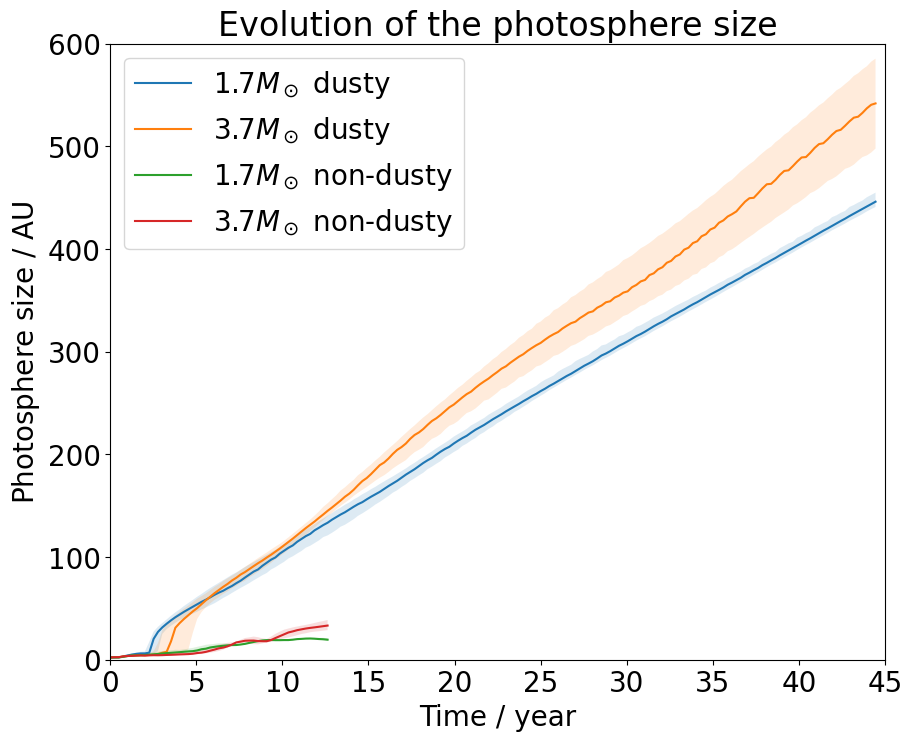

In [46]:
# ph size vs time
if __name__ == '__main__':
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = {
        '2md': "$1.7M_\\odot$ dusty",
        '4md': "$3.7M_\\odot$ dusty",
        '2m_2022': "$1.7M_\\odot$ non-dusty",
        '4m' : "$3.7M_\\odot$ non-dusty",
    }
    
    for job_nickname in labels.keys():
        x  = data[job_nickname]['times']
        y  = np.array(data[job_nickname]['R1sph_avg'])
        ys = np.array(data[job_nickname]['R1sph'])
        ax.plot(x, ys[..., 0], label=labels[job_nickname])    #
        ax.fill_between(x, ys[..., 1], ys[..., 2], alpha=0.15)
    ax.legend()
    ax.set_title("Evolution of the photosphere size")
    ax.set_xlabel("Time / year")
    ax.set_ylabel(f"Photosphere size / {unitsOutTxt['dist']}")
    ax.set_xlim(0., 45.)
    ax.set_ylim(0., 600.)
    outfilename = f"{out_dir}photosphere_R1ph-t.jpg"
    fig.savefig(outfilename)
    

In [17]:
np.where(np.array(data['2md']['times']) > 12.)[0]

array([ 48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,
        61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,
        74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,
        87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,
       100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
       113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
       126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
       139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
       152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
       165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176])

In [20]:
data['2md']['temps_avg'][40:50]

[521.4598692426487,
 522.3247000548727,
 519.7726768411493,
 518.1956703425473,
 516.9947766272819,
 517.0080103937383,
 516.3869559038927,
 513.0761628855739,
 511.76694802100235,
 510.21859880680404]

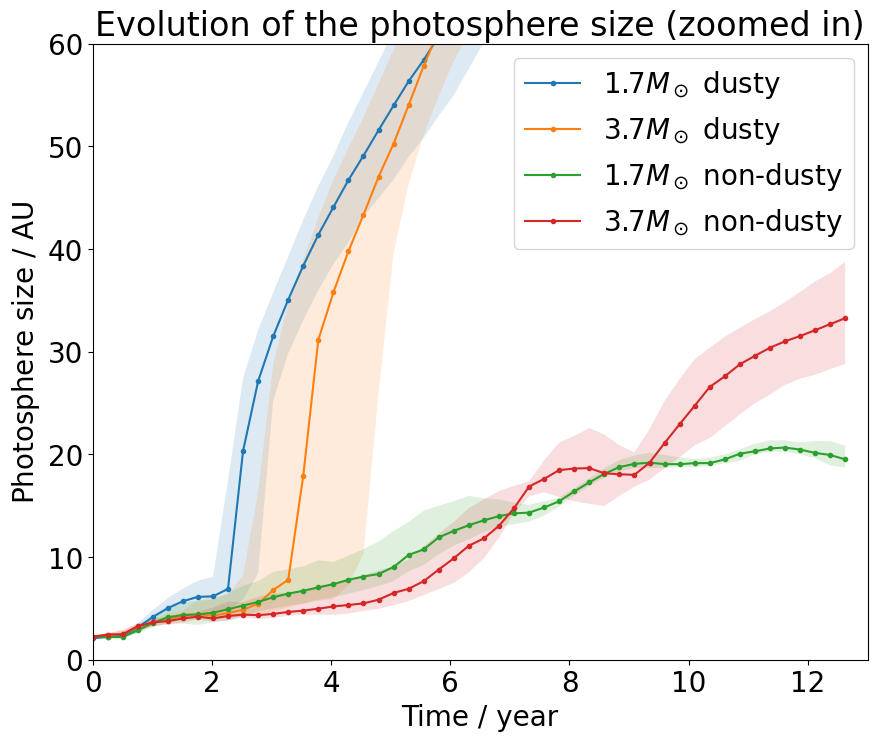

In [47]:
# ph size vs time (zoomed in)
if __name__ == '__main__':

    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = {
        '2md': "$1.7M_\\odot$ dusty",
        '4md': "$3.7M_\\odot$ dusty",
        '2m_2022': "$1.7M_\\odot$ non-dusty",
        '4m' : "$3.7M_\\odot$ non-dusty",
    }
    
    for job_nickname in labels.keys():
        x  = data[job_nickname]['times']
        y  = np.array(data[job_nickname]['R1sph_avg'])
        ys = np.array(data[job_nickname]['R1sph'])
        ax.plot(x, ys[..., 0], '.-', label=labels[job_nickname])    #ys[..., 0]
        ax.fill_between(x, ys[..., 1], ys[..., 2], alpha=0.15)
        
    ax.legend()
    ax.set_title("Evolution of the photosphere size (zoomed in)")
    ax.set_xlabel("Time / year")
    ax.set_ylabel(f"Photosphere size / {unitsOutTxt['dist']}")
    ax.set_xlim(0., 13.)
    ax.set_ylim(0., 60.)
    outfilename = f"{out_dir}photosphere_R1ph-t_zoomed-in.jpg"
    fig.savefig(outfilename)
    

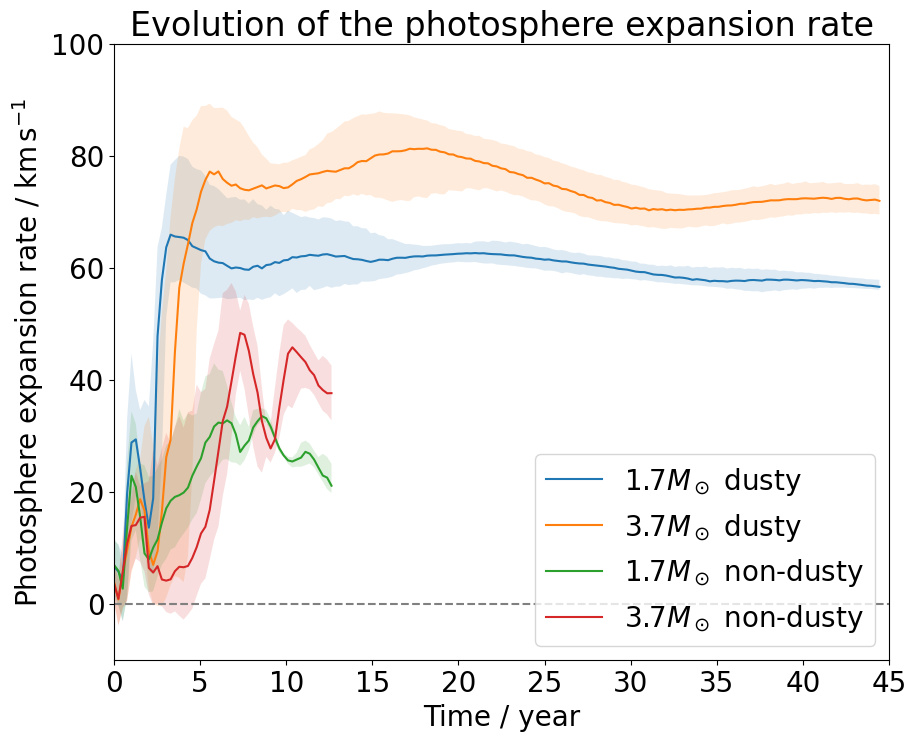

In [9]:
# ph size vs time (zoomed in)
if __name__ == '__main__':

    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = {
        '2md': "$1.7M_\\odot$ dusty",
        '4md': "$3.7M_\\odot$ dusty",
        '2m_2022': "$1.7M_\\odot$ non-dusty",
        '4m' : "$3.7M_\\odot$ non-dusty",
    }
    
    for job_nickname in labels.keys(): #('2md', '4md',):#labels.keys():
        x  = data[job_nickname]['times']
        #y  = np.array(data[job_nickname]['R1sph_avg'])
        ys = np.array(data[job_nickname]['vrsph'])
        ax.plot(x, ys[..., 0], '-', label=labels[job_nickname])    #ys[..., 0]
        ax.fill_between(x, ys[..., 1], ys[..., 2], alpha=0.15)
        
    ax.legend()
    ax.axhline(0., color='grey', linestyle='dashed')
    ax.set_title("Evolution of the photosphere expansion rate")
    ax.set_xlabel("Time / year")
    ax.set_ylabel(f"Photosphere expansion rate / {unitsOutTxt['speed']}")
    ax.set_xlim(0., 45.)
    ax.set_ylim(-10., 100.)
    outfilename = f"{out_dir}photosphere_vrph-t.jpg"
    fig.savefig(outfilename)
    

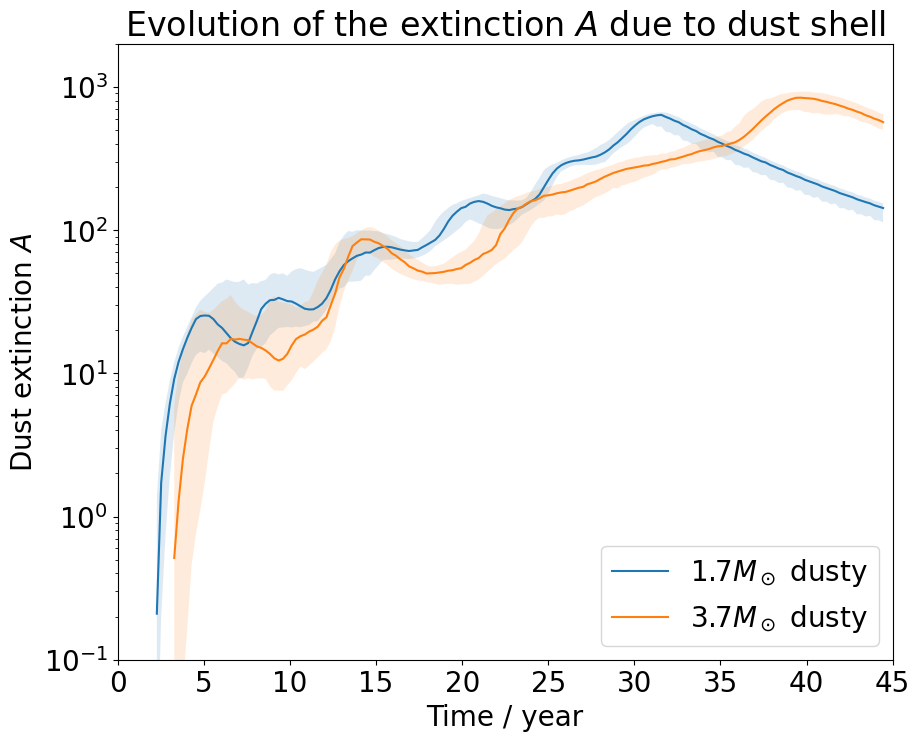

In [12]:
# ph size vs time
if __name__ == '__main__':
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = {
        '2md': "$1.7M_\\odot$ dusty",
        '4md': "$3.7M_\\odot$ dusty",
        '2m_2022': "$1.7M_\\odot$ non-dusty",
        '4m' : "$3.7M_\\odot$ non-dusty",
    }
    
    for job_nickname in ('2md', '4md',): #labels.keys():
        x  = data[job_nickname]['times']
        ys = np.array(data[job_nickname]['tausd']) * 2.5 / np.log(10)
        ax.semilogy(x, ys[..., 0], label=labels[job_nickname])    #
        ax.fill_between(x, ys[..., 1], ys[..., 2], alpha=0.15)
    ax.legend(loc='lower right')
    ax.set_title("Evolution of the extinction $A$ due to dust shell")
    ax.set_xlabel("Time / year")
    ax.set_ylabel(f"Dust extinction $A$")
    ax.set_xlim(0., 45.)
    ax.set_ylim(0.1, 2e3)
    outfilename = f"{out_dir}photosphere_taud-t.jpg"
    fig.savefig(outfilename)
    

In [107]:
# getting the ph expansion rate
for job_nickname in ('2md', '4md',):
    ind = np.where(times>10)[0][0]
    times = np.array(data[job_nickname]['times'])
    R1sph = np.array(data[job_nickname]['R1sph'])
    R1sph_cov = np.polyfit(times[ind:], R1sph[ind:, 0], 1)
    print(job_nickname, R1sph_cov)


2md [ 9.85711283 11.89200801]
4md [12.20378984 -2.28599442]


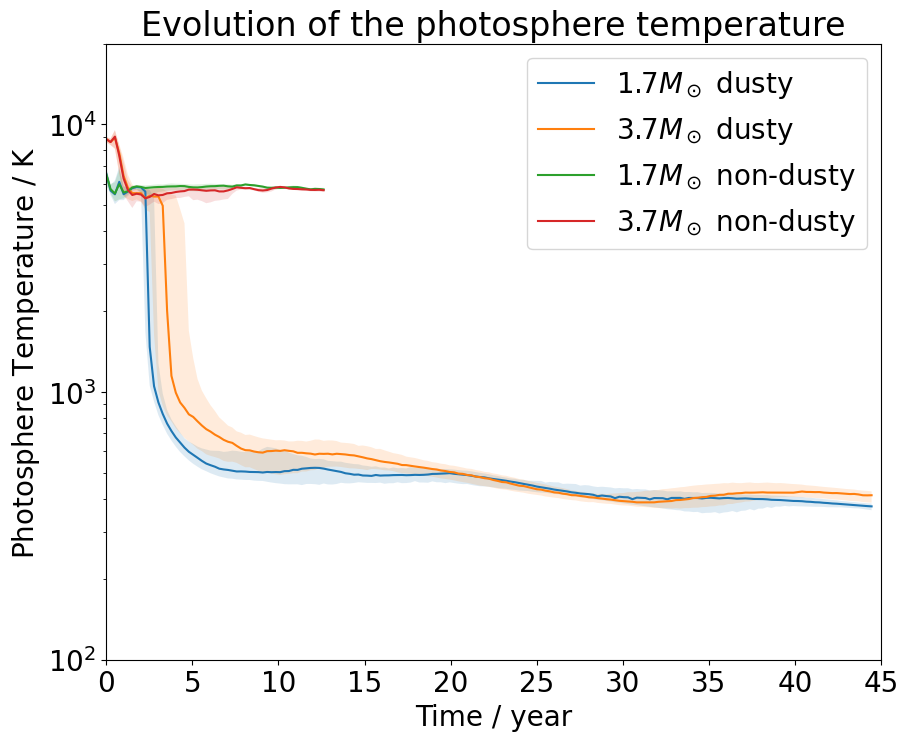

In [51]:
# ph temp vs time
if __name__ == '__main__':
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = {
        '2md': "$1.7M_\\odot$ dusty",
        '4md': "$3.7M_\\odot$ dusty",
        '2m_2022': "$1.7M_\\odot$ non-dusty",
        '4m' : "$3.7M_\\odot$ non-dusty",
    }
    
    for job_nickname in labels.keys():
        x  = data[job_nickname]['times']
        y  = np.array(data[job_nickname]['temps_avg'])
        ys = np.array(data[job_nickname]['temps'])
        ax.semilogy(x, ys[..., 0], label=labels[job_nickname])    #ys[..., 0]
        ax.fill_between(x, ys[..., 1], ys[..., 2], alpha=0.15)
    ax.legend()
    ax.set_title("Evolution of the photosphere temperature")
    ax.set_xlabel("Time / year")
    ax.set_ylabel(f"Photosphere Temperature / {unitsOutTxt['temp']}")
    ax.set_xlim(0., 45.)
    ax.set_ylim(100., 20000.)
    outfilename = f"{out_dir}photosphere_temp-t.jpg"
    fig.savefig(outfilename)
    

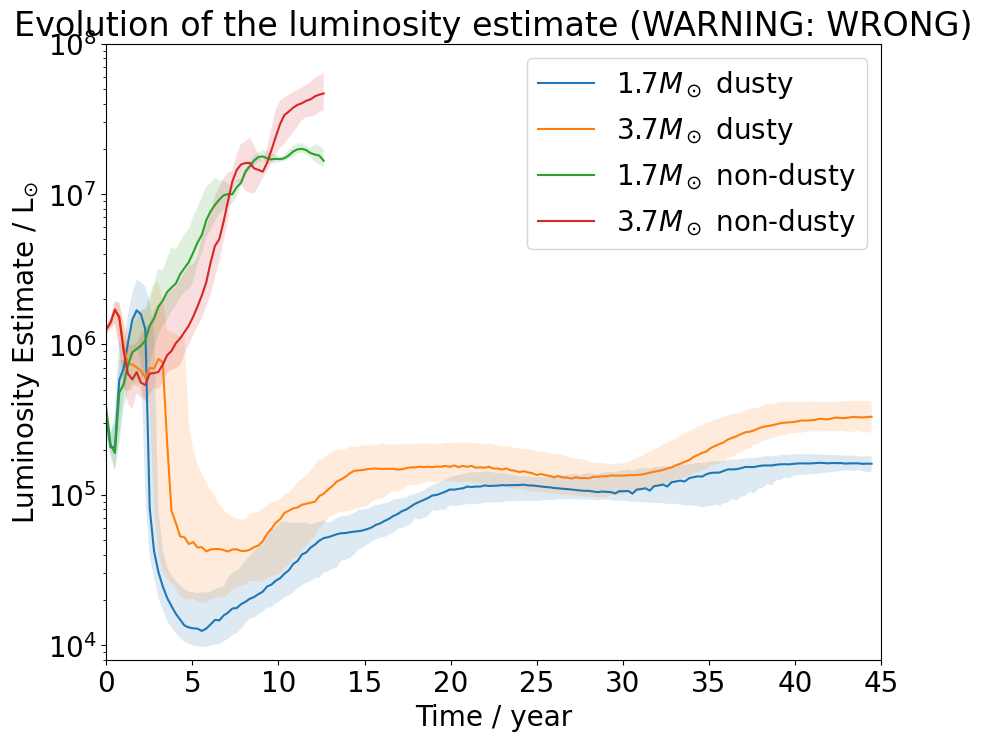

In [52]:
# ph temp vs time
if __name__ == '__main__':
    plt.close()
    fig, ax = plt.subplots(figsize=(10, 8))
    labels = {
        '2md': "$1.7M_\\odot$ dusty",
        '4md': "$3.7M_\\odot$ dusty",
        '2m_2022': "$1.7M_\\odot$ non-dusty",
        '4m' : "$3.7M_\\odot$ non-dusty",
    }
    
    for job_nickname in labels.keys():
        x  = data[job_nickname]['times']
        #y  = np.array(data[job_nickname]['lums_avg'])
        ys = np.array(data[job_nickname]['lums'])
        ax.semilogy(x, ys[..., 0], label=labels[job_nickname])    #ys[..., 0]
        ax.fill_between(x, ys[..., 1], ys[..., 2], alpha=0.15)
    ax.legend()
    ax.set_title("Evolution of the luminosity estimate (WARNING: WRONG)")
    ax.set_xlabel("Time / year")
    ax.set_ylabel(f"Luminosity Estimate / {units.Lsun.to_string('latex_inline')}")
    ax.set_xlim(0., 45.)
    ax.set_ylim(8e3, 1e8)
    outfilename = f"{out_dir}photosphere_lum-t.jpg"
    fig.savefig(outfilename)
    

In [152]:
job_nickname = '2md'
box_lims = data[job_nickname]['box_lims']
R1s_avg   = data[job_nickname]['R1s_avg']
temps_max = data[job_nickname]['temps_max']
temps_min = data[job_nickname]['temps_min']
temps_avg = data[job_nickname]['temps_avg']
box_lim_cov = np.array([
    (np.max(box_lims[-1]) - box_lims[0]) / (times[-1] - times[0]),
    box_lims[0],
])

print(f"{job_nickname}:")
print(f"\tbox_lim = ({box_lim_cov[1]} + {box_lim_cov[0]} * time/yr) {unitsOut['dist']} ")

2md:
	box_lim = (3.0 + 11.565782397007524 * time/yr) AU 


In [142]:
box_lim_cov = np.array([
    (np.max(box_lims[-1]) - box_lims[0]) / (times[-1] - times[0]),
    box_lims[0],
])
box_lim_calced = np.polyval(box_lim_cov, times)
box_lim_calced

array([  3.        ,   5.92045455,   8.84090909,  11.76136364,
        14.68181818,  17.60227273,  20.52272727,  23.44318182,
        26.36363636,  29.28409091,  32.20454545,  35.125     ,
        38.04545455,  40.96590909,  43.88636364,  46.80681818,
        49.72727273,  52.64772727,  55.56818182,  58.48863636,
        61.40909091,  64.32954545,  67.25      ,  70.17045455,
        73.09090909,  76.01136364,  78.93181818,  81.85227273,
        84.77272727,  87.69318182,  90.61363636,  93.53409091,
        96.45454545,  99.375     , 102.29545455, 105.21590909,
       108.13636364, 111.05681818, 113.97727273, 116.89772727,
       119.81818182, 122.73863636, 125.65909091, 128.57954545,
       131.5       , 134.42045455, 137.34090909, 140.26136364,
       143.18181818, 146.10227273, 149.02272727, 151.94318182,
       154.86363636, 157.78409091, 160.70454545, 163.625     ,
       166.54545455, 169.46590909, 172.38636364, 175.30681818,
       178.22727273, 181.14772727, 184.06818182, 186.98

In [148]:
R1s_calced

array([  1.97112796,   4.54959668,   7.12806541,   9.70653413,
        12.28500285,  14.86347157,  17.44194029,  20.02040902,
        22.59887774,  25.17734646,  27.75581518,  30.3342839 ,
        32.91275262,  35.49122135,  38.06969007,  40.64815879,
        43.22662751,  45.80509623,  48.38356495,  50.96203368,
        53.5405024 ,  56.11897112,  58.69743984,  61.27590856,
        63.85437728,  66.43284601,  69.01131473,  71.58978345,
        74.16825217,  76.74672089,  79.32518961,  81.90365834,
        84.48212706,  87.06059578,  89.6390645 ,  92.21753322,
        94.79600195,  97.37447067,  99.95293939, 102.53140811,
       105.10987683, 107.68834555, 110.26681428, 112.845283  ,
       115.42375172, 118.00222044, 120.58068916, 123.15915788,
       125.73762661, 128.31609533, 130.89456405, 133.47303277,
       136.05150149, 138.62997021, 141.20843894, 143.78690766,
       146.36537638, 148.9438451 , 151.52231382, 154.10078254,
       156.67925127, 159.25771999, 161.83618871, 164.41

49646.9057637105, 450882.7581221053


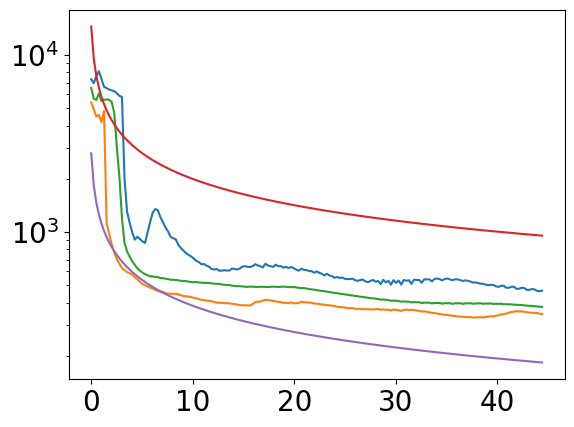

In [160]:
#cutoff_ind = np.where(np.array(times) > 10)[0][0]
R1s_cov = np.polyfit(times, R1s_avg, 1)
R1s_calced = np.polyval(R1s_cov, times)
temps_lim_raw = ((units.Lsun / ((    R1s_calced*unitsOut['dist'])**2 * 4*pi * const.sigma_sb))**0.25).to_value(units.K)
#temps_lim_raw = ((units.Lsun / ((box_lim_calced*unitsOut['dist'])**2 * 4*pi * const.sigma_sb))**0.25).to_value(units.K)
# note: times_lim_max_factor**4 is the lum for a photosphere with eff temp of temp_lim and size of box_lim
temps_lim_max_factor = np.average((temps_max / temps_lim_raw))#np.max(temps_max / temps_lim_raw)
temps_lim_min_factor = np.average(temps_min / temps_lim_raw)
print(f"{temps_lim_min_factor**4}, {temps_lim_max_factor**4}")
temps_lim_max = temps_lim_max_factor * temps_lim_raw * 2.
temps_lim_min = temps_lim_min_factor * temps_lim_raw / 1.5
plt.semilogy(times, temps_max)
plt.semilogy(times, temps_min)
plt.semilogy(times, temps_avg)
plt.semilogy(times, temps_lim_max)
plt.semilogy(times, temps_lim_min)

In [122]:
temps_lim_min_factor**4, temps_lim_max_factor**4

(65149.89723781501, 593479.6890230301)

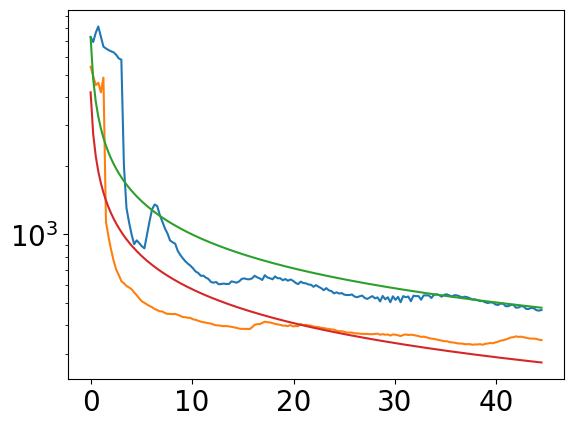

In [144]:
plt.semilogy(times, temps_max)
plt.semilogy(times, temps_min)
plt.semilogy(times, temps_lim_max)
plt.semilogy(times, temps_lim_min)

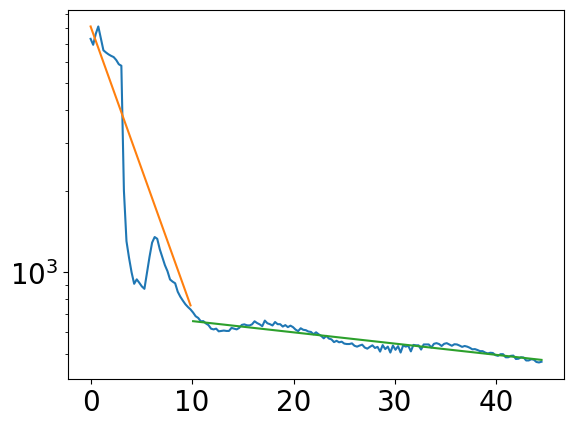

In [66]:
cutoff_ind = np.where(np.array(times) > 10)[0][0]
temp_cov0 = np.array([
    (np.log10(temps_max[cutoff_ind]) - np.max(np.log10(temps_max[:cutoff_ind]))) / (times[cutoff_ind] - times[0]),
    np.max(np.log10(temps_max[:cutoff_ind])),
    ])    #np.polyfit(times[:cutoff_ind], np.log10(temps_max[:cutoff_ind]), 1)
temp_cov1 = np.polyfit(times[cutoff_ind:], np.log10(temps_max[cutoff_ind:]), 1)
plt.semilogy(times, temps_max)
plt.semilogy(times[:cutoff_ind], 10**np.polyval(temp_cov0, times[:cutoff_ind]))
plt.semilogy(times[cutoff_ind:], 10**np.polyval(temp_cov1, times[cutoff_ind:]))


In [31]:
np.polyfit(times, temps_max, 1)

array([ -65.99285504, 2552.60077446])

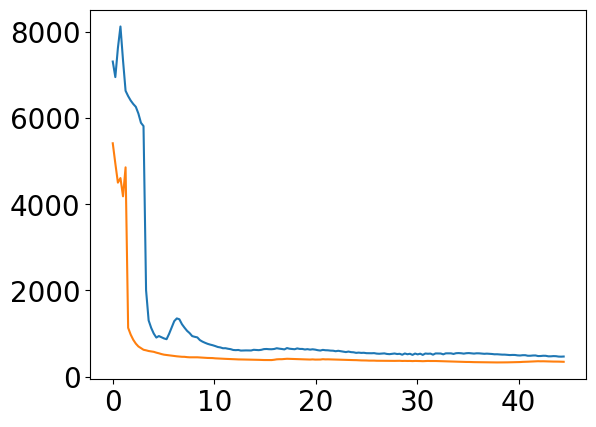

In [53]:
plt.plot(times, temps_max)
plt.plot(times, temps_min)

70.0


(<Figure size 1200x1200 with 2 Axes>,
 <Axes3D: title={'center': 'Photosphere 3D scatter plot\n for 3.7$\\mathrm{M_{\\odot}}$ primary star with Nucleation Dust\nt = 5.05 yr\n$R_\\mathrm{ph}$ = 48.35$\\pm$ 11.94 AU\n$T_\\mathrm{ph}$ = 1117.13$\\pm$ 964.85 K'}, xlabel='\n$x$ / $\\mathrm{AU}$', ylabel='\n$y$ / $\\mathrm{AU}$', zlabel='\n$z$ / $\\mathrm{AU}$'>,
 '../fig/4md_ph-3d-02000.jpg')

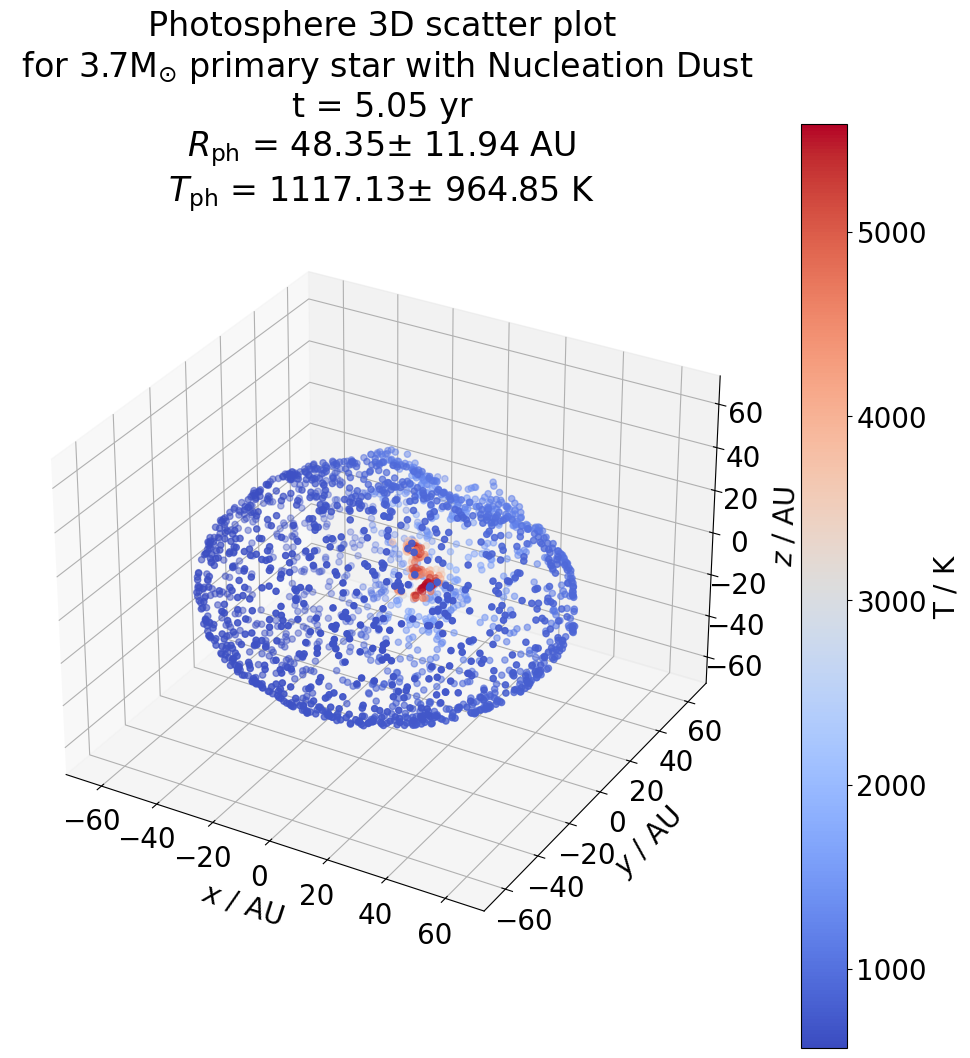

In [9]:
plot_ph_3d_scatter('4md', 2000, out_dir=out_dir, norm=mpl.cm.lo)

In [ ]:
# making movies



In [12]:
# testing
if __name__ == '__main__':
    job_nickname= '4md'
    file_index  = 2000
    job_profile = JOB_PROFILES_DICT[job_nickname]
    job_name    = job_profile['job_name']
    plot_title_suffix = job_profile['plot_title_suffix']
    params      = job_profile['params']
    #ieos        = job_profile['ieos']
    #eos         = get_eos(ieos, params, settings)
    eos_opacity = EoS_MESA_opacity(params, settings)
    mpdf        = mpdf_read(job_name, file_index, eos_opacity, None, verbose=verbose)
    with open(f"{mupl.get_filename_phantom_dumps(job_name, file_index)}__photosphere-vals.json", 'r') as f:
        vals_dict = json_load(f)
        vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_02000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([ 0.23937172 -0.2316362   0.15263956])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [1.53751730e-15 0.00000000e+00 8.20009226e-16]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])


In [13]:
vals_dict

{'tau_dust': array([17.90571491,  7.69594384, 14.61236931,  1.59462891, 23.63789046,
         2.35262372,  2.6295465 , 20.4389646 ,  1.33087645,  2.25684304,
        24.49103714,  3.58093349,  1.55064822,  0.73398331, 23.72317664,
         1.48951542,  9.0447713 ,  0.68615165,  6.7526077 ,  2.29678071]),
 'inner_dust_shell_rad': <Quantity [6946.91223204, 5091.02565339, 8225.93269672, 5798.61003377,
            6951.61712182, 6982.24226881, 7616.26309884, 6348.63835323,
            6960.65727912, 6524.74833088, 5466.43911945, 7882.40921875,
            4898.54126295, 7880.07866152, 5857.84959366, 4954.46804497,
            6607.00537979, 6612.48492935, 7183.98439564, 6969.11675728] 6.9595e+10 cm>,
 'R1': <Quantity [13322.20713367,  9494.56247319, 13102.03544288,  7748.44971317,
            12399.6318479 ,  9356.29951565, 10426.54955663, 11444.66110103,
             7608.81134283,  8752.0392066 , 11959.35588868, 11095.3407344 ,
             6481.2406503 ,  3565.69871633, 12271.38674775, 

(<Figure size 1000x800 with 2 Axes>,
 <Axes: title={'center': 'Cross-Section at z = 0.0\nresolution = 1.37e+06'}, xlabel='x', ylabel='y'>)

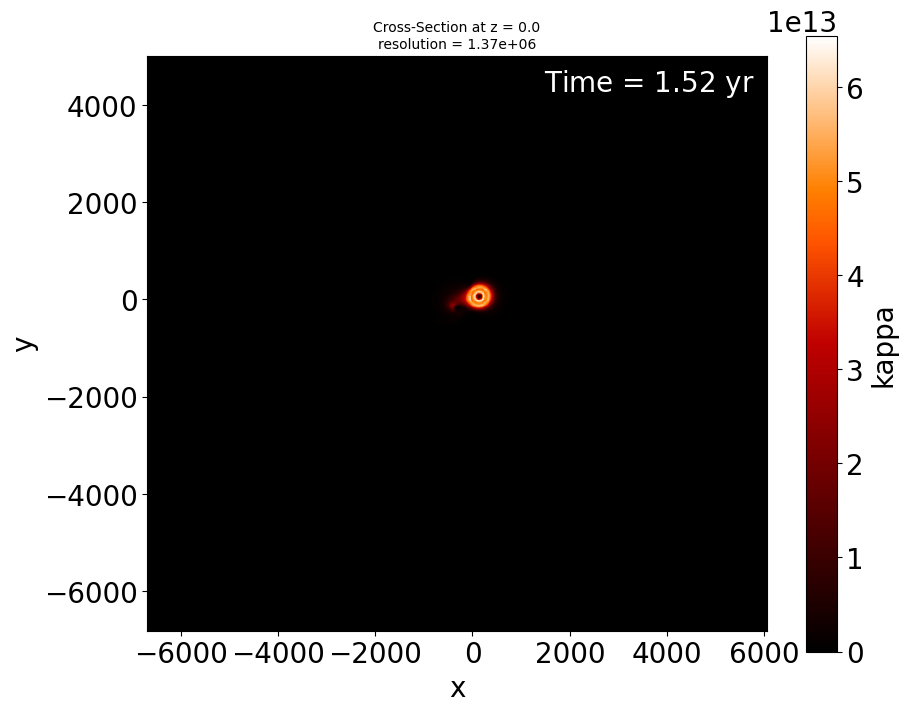

In [8]:
mpdf.plot_render(rendered='kappa', norm=None)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([9.36841334e-13 3.02453466e-14 2.47169186e-14])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 0.00000000e+00  3.59257537e-16 -1.80945419e-16]


Exception ignored on calling ctypes callback function: <function ExecutionEngine._raw_object_cache_notify at 0x1482ee4e79c0>
Traceback (most recent call last):
  File "/home/clmu/anaconda3/envs/clmu_1/lib/python3.11/site-packages/llvmlite/binding/executionengine.py", line 171, in _raw_object_cache_notify
    def _raw_object_cache_notify(self, data):

KeyboardInterrupt: 


**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
vr [ 1.59183576 13.32364345  4.11465281 ...  5.58976561  1.09332137
 10.45101391]
*   Note   :    plot_ph_vals_vs_incl():
	Figure saved to ../fig/2md_00000__photosphere-vals_vr-vs-incl_nbin0.png
*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_02000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([-0.73535108  1.00341079 -0.30761575])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [-3.08171492e-15  4.23735801e-15  1.68531284e-15]
**  Warning:    MyPhantomData

Moviepy - Done !
Moviepy - video ready ../fig/2md__photosphere-vals_vr-vs-incl_nbin0__movie.mp4
*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([-2.20418480e-12  6.61602903e-15  3.42743236e-15])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [1.31201476e-14 2.05272573e-15 1.66394206e-15]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
vr [10.38346751  3.00453933  3.87925636 ...  0.88873777  5.86923182
  3.58815307]
*   Note   :    plot_ph_vals_vs_incl(

Moviepy - Done !
Moviepy - video ready ../fig/4md__photosphere-vals_vr-vs-incl_nbin0__movie.mp4
*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([9.36841334e-13 3.02453466e-14 2.47169186e-14])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [ 0.00000000e+00  3.59257537e-16 -1.80945419e-16]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
vr [ 1.59183576 13.32364345  4.11465281 ...  5.58976561  1.09332137
 10.45101391]
*   Note   :    plot_ph_vals_vs_incl(

Moviepy - Done !
Moviepy - video ready ../fig/2md__photosphere-vals_vr-vs-incl_nbin40__movie.mp4
*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_00000'


*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	Reseting Origin to CoM ([-2.20418480e-12  6.61602903e-15  3.42743236e-15])...
*   Note   :    MyPhantomDataFrames.reset_xyz_by():
	CoM location is now [1.31201476e-14 2.05272573e-15 1.66394206e-15]
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
vr [10.38346751  3.00453933  3.87925636 ...  0.88873777  5.86923182
  3.58815307]
*   Note   :    plot_ph_vals_vs_incl

Moviepy - Done !
Moviepy - video ready ../fig/4md__photosphere-vals_vr-vs-incl_nbin40__movie.mp4
*   Note   :    __main__:
	


*** All Done. ***





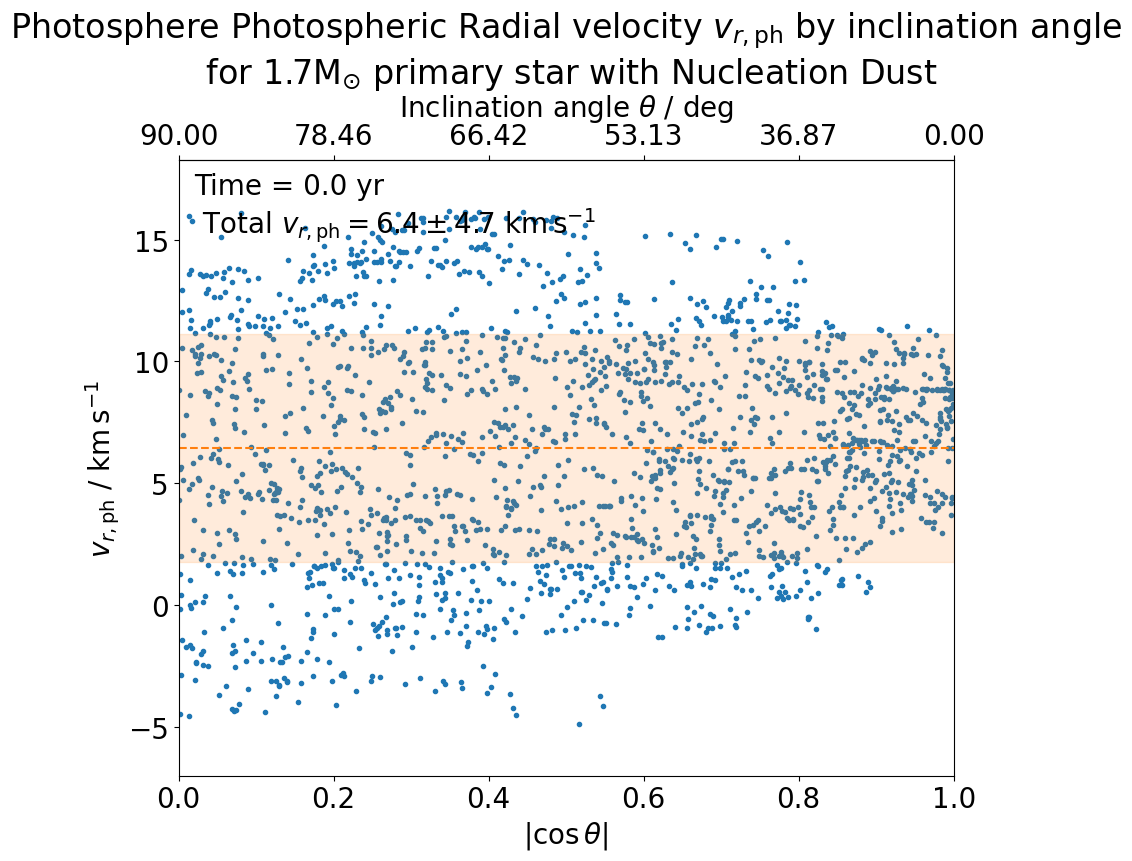

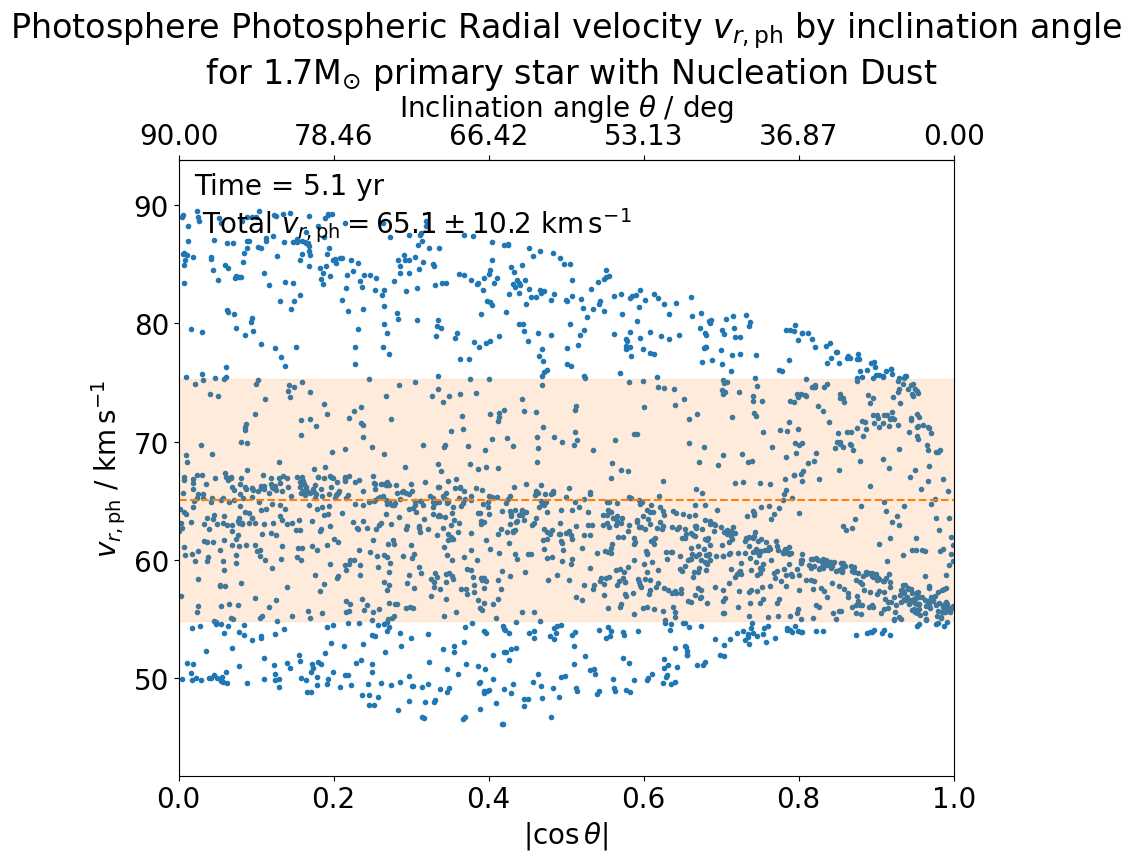

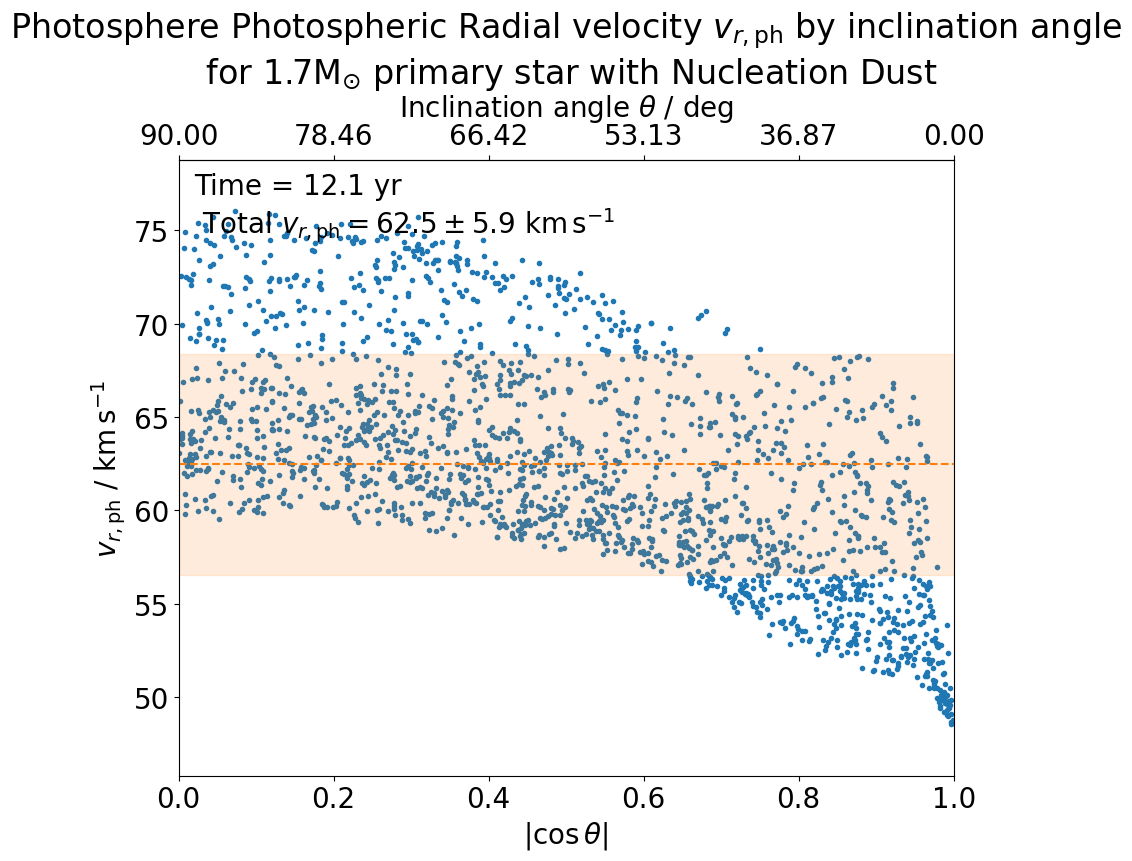

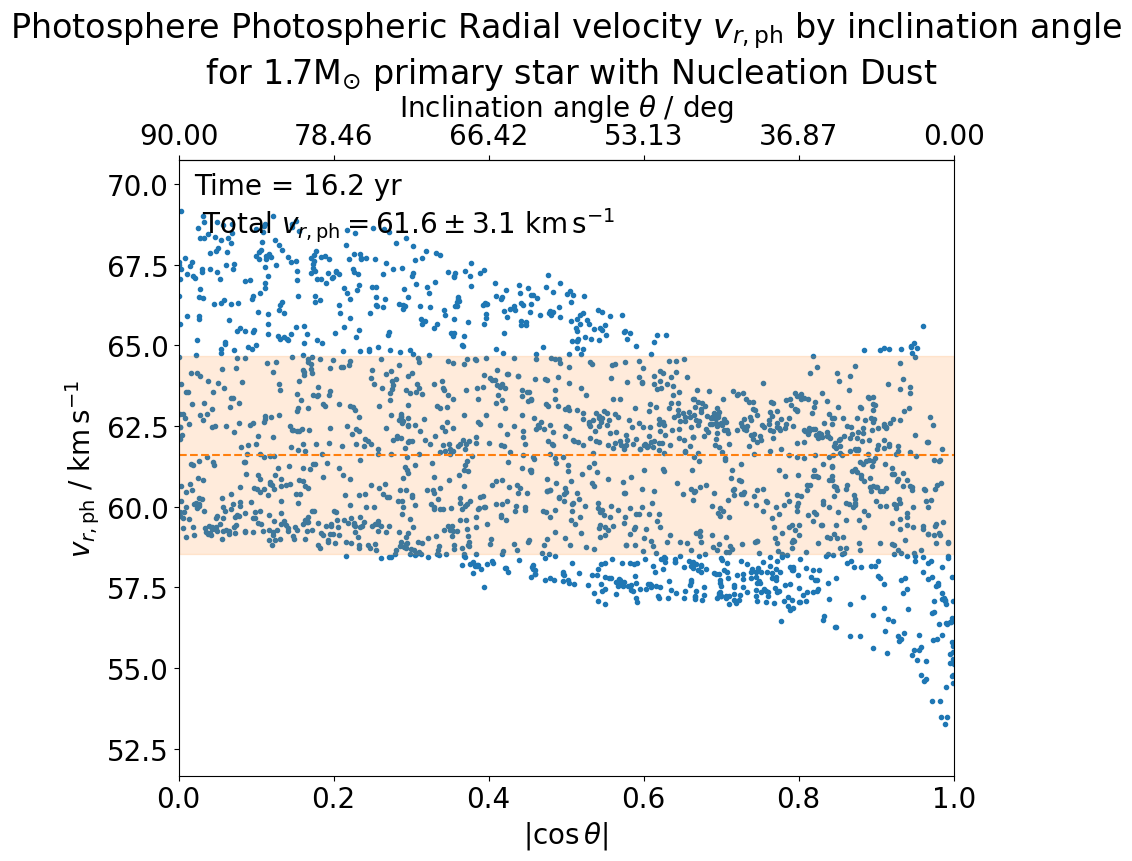

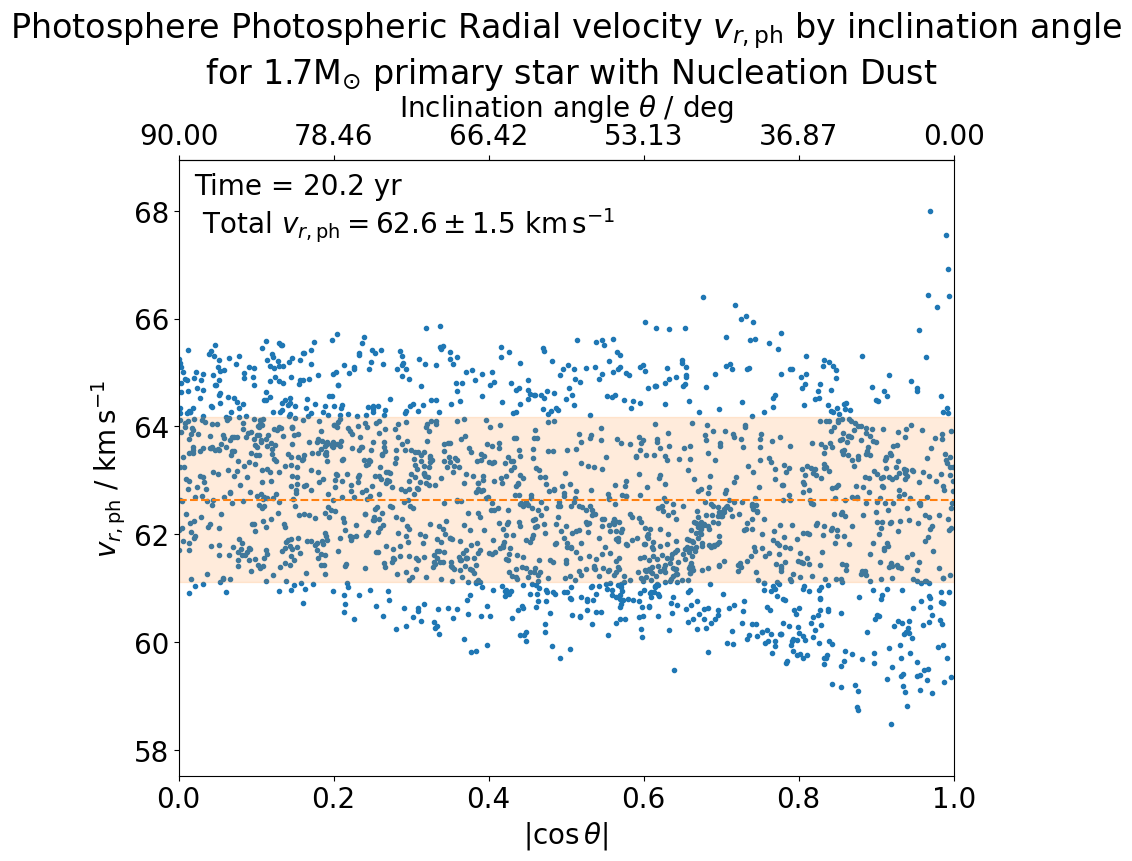

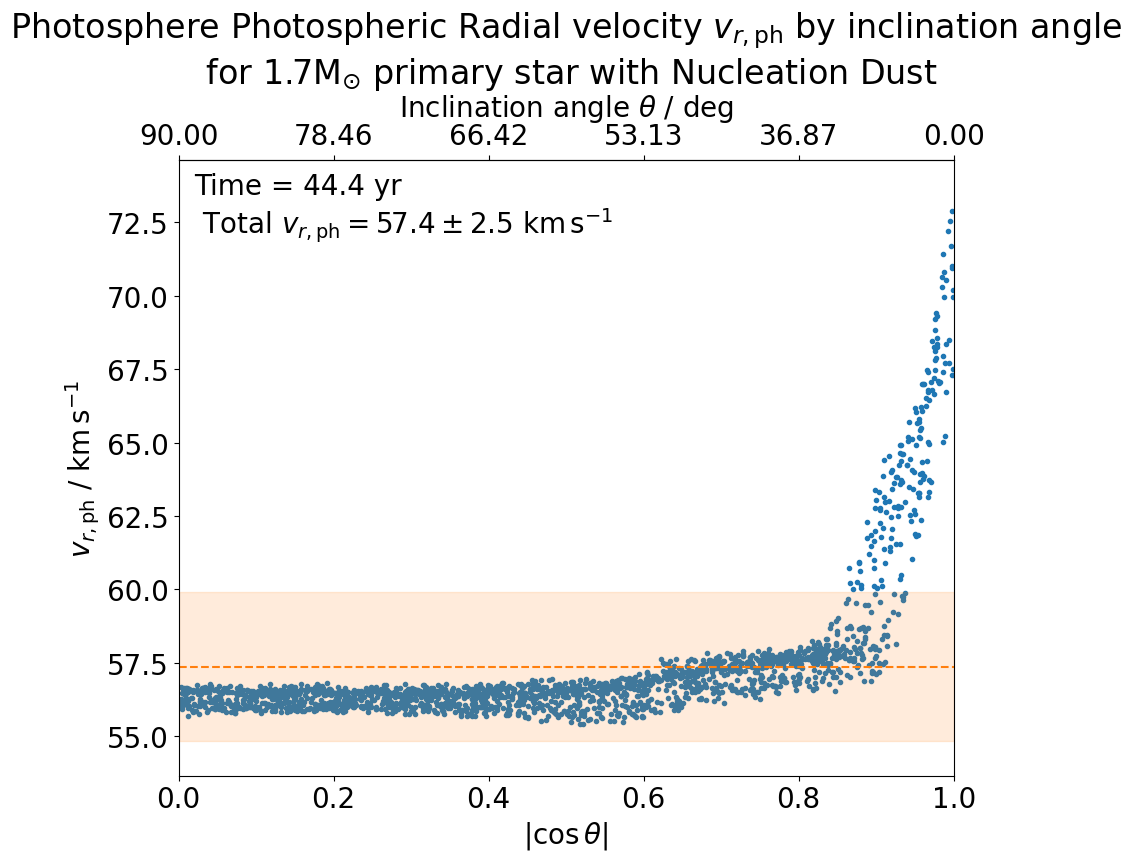

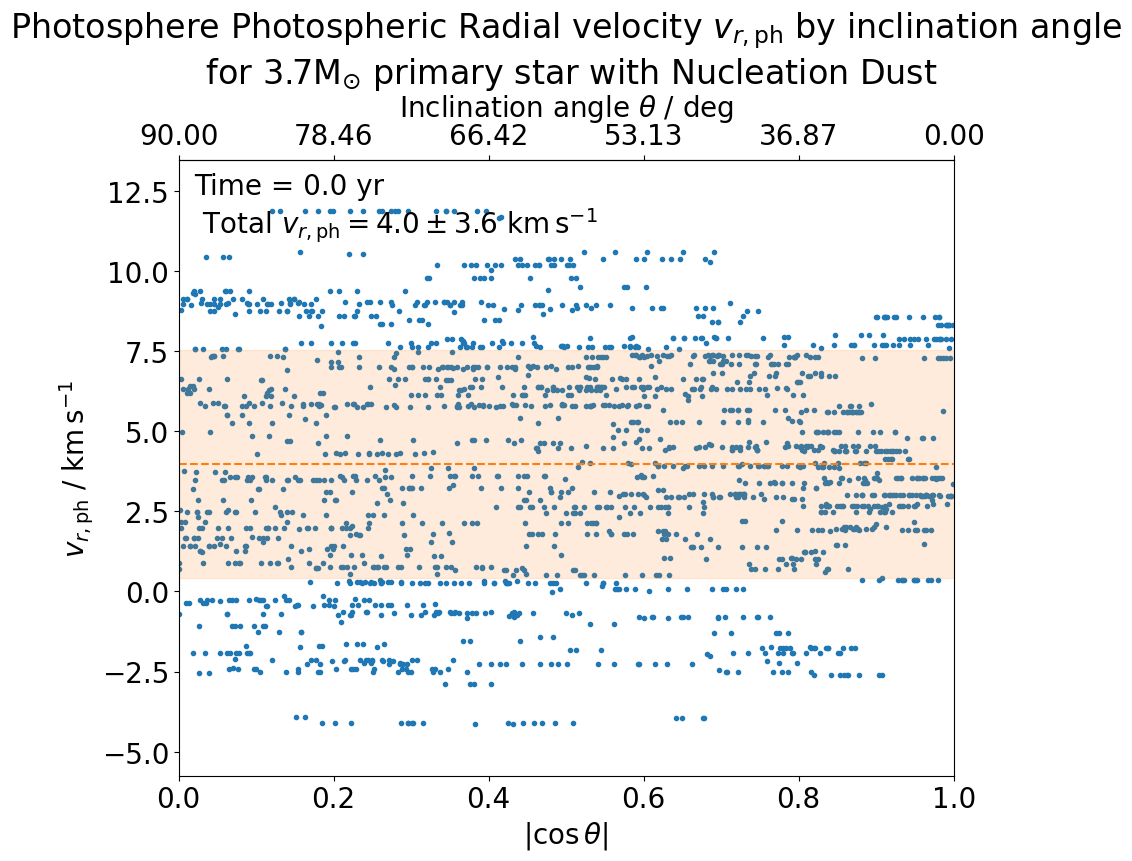

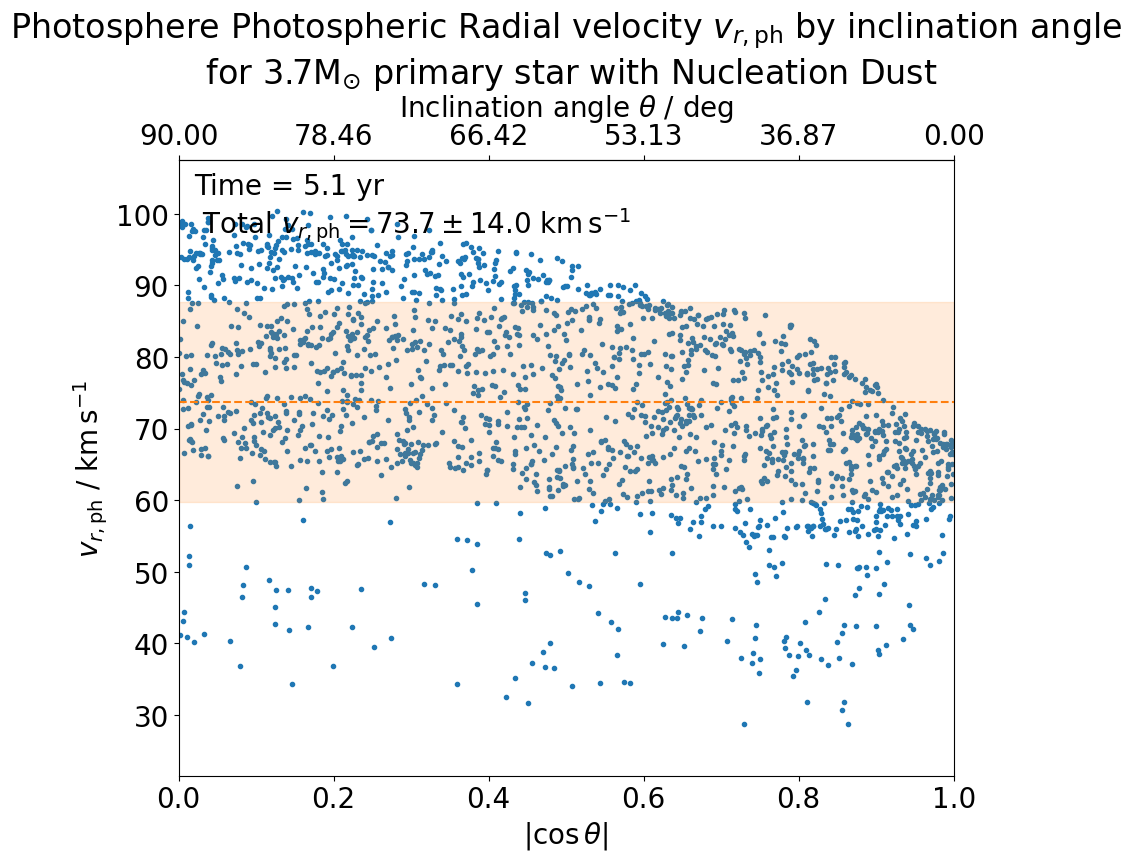

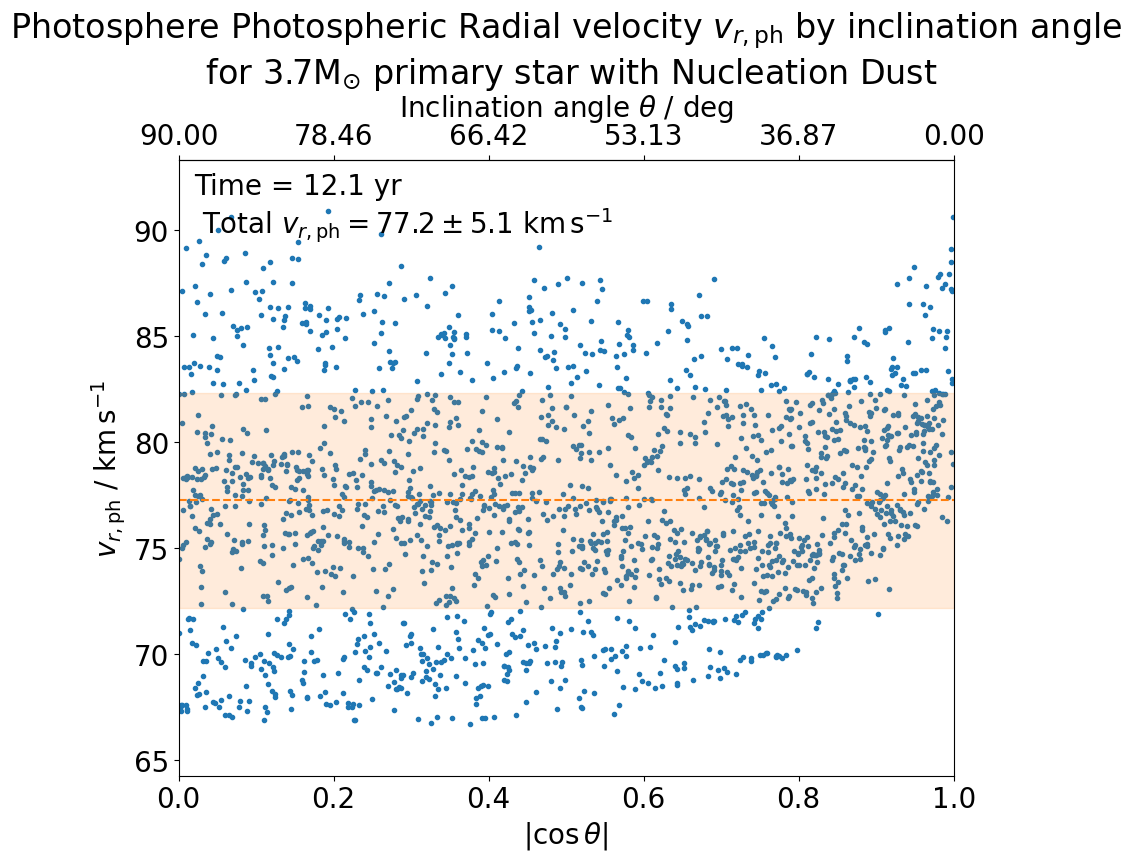

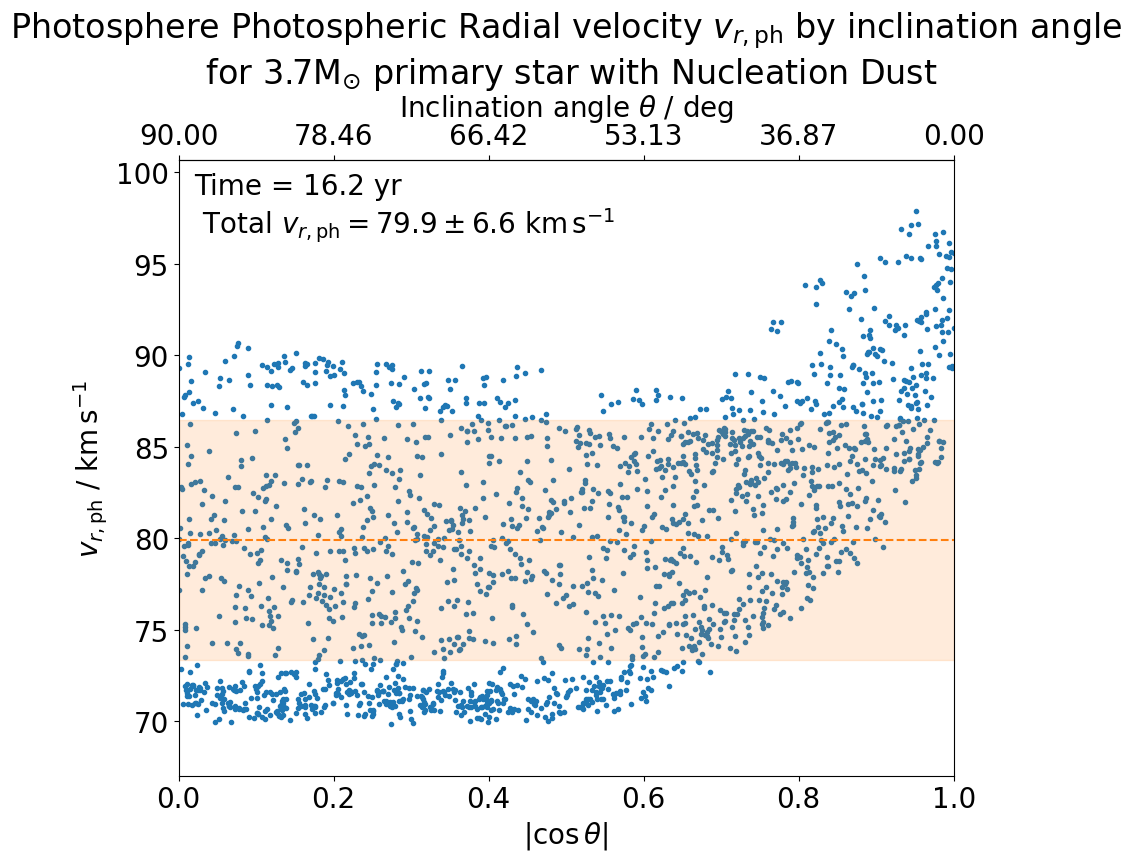

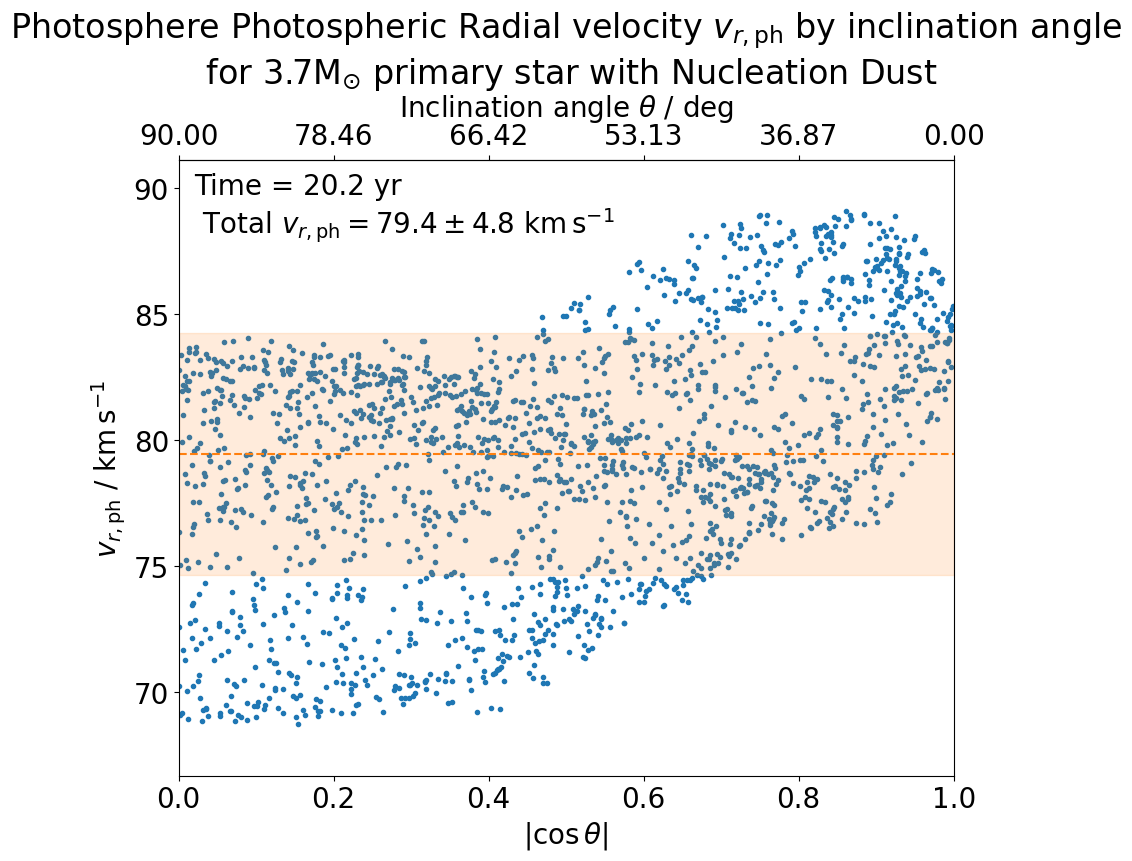

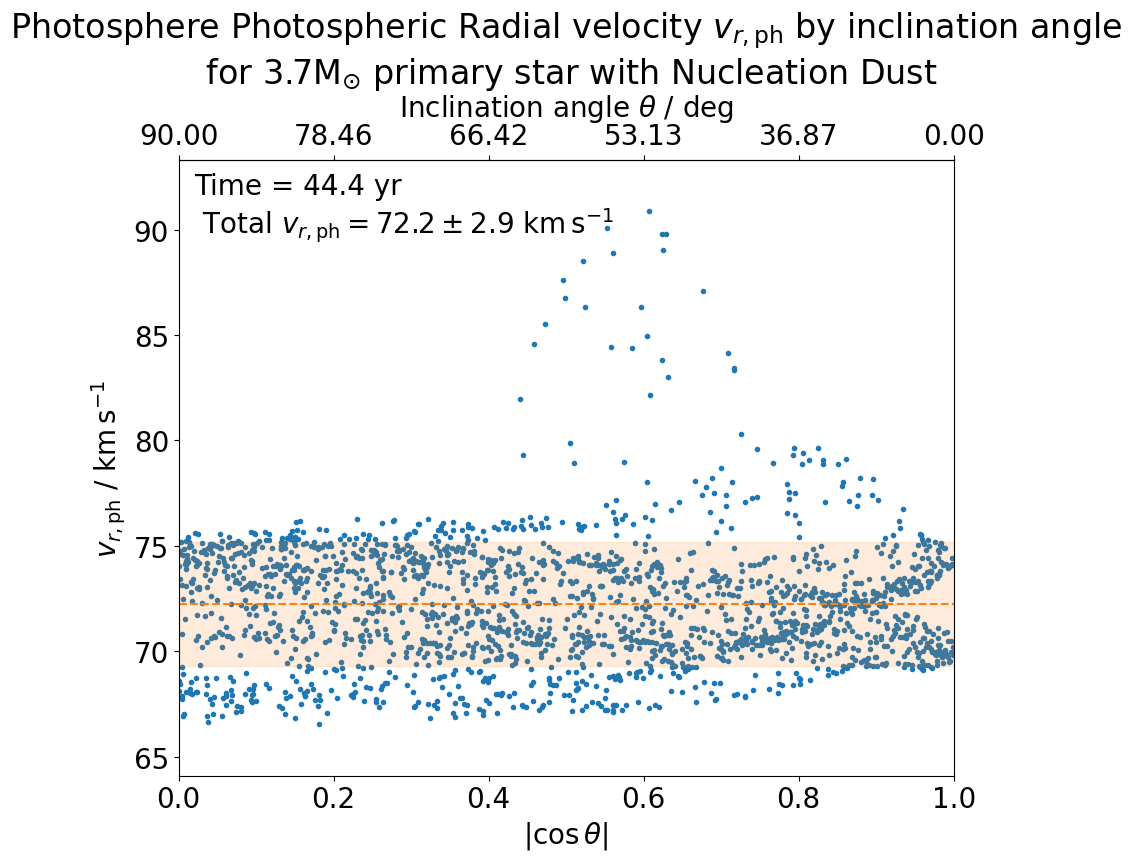

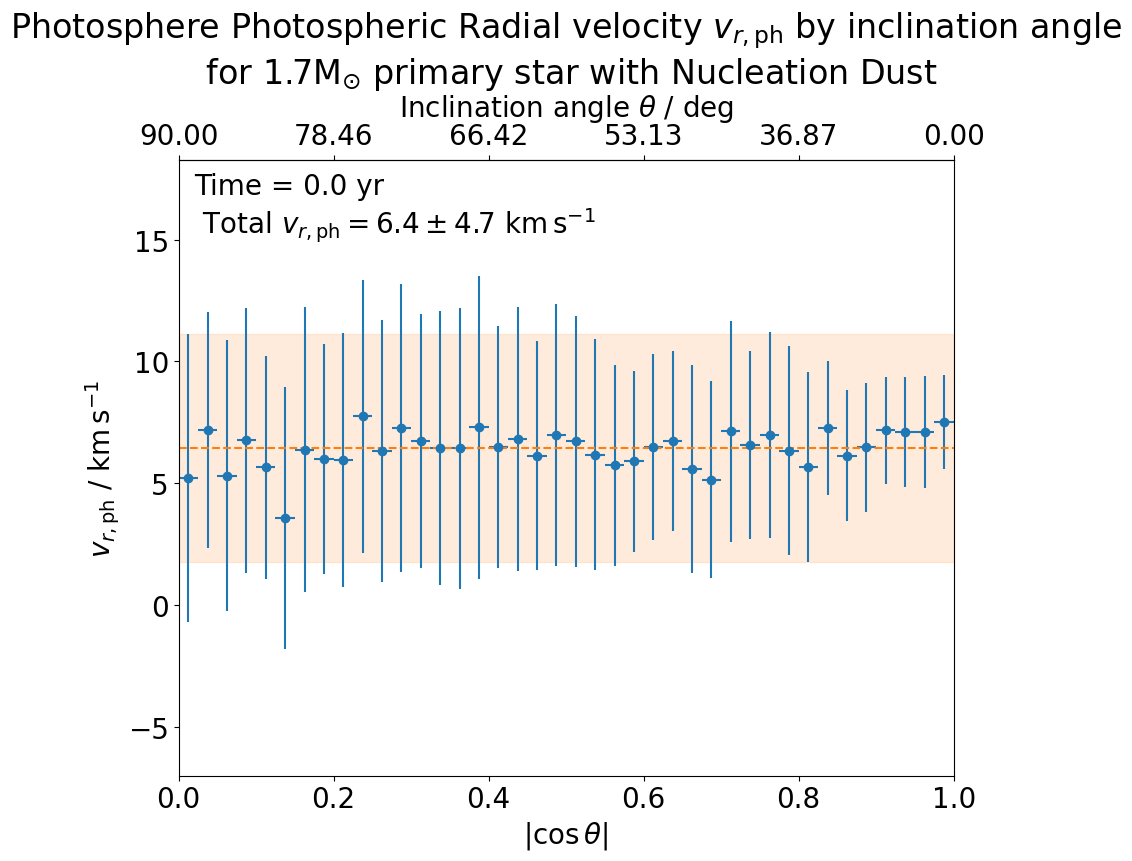

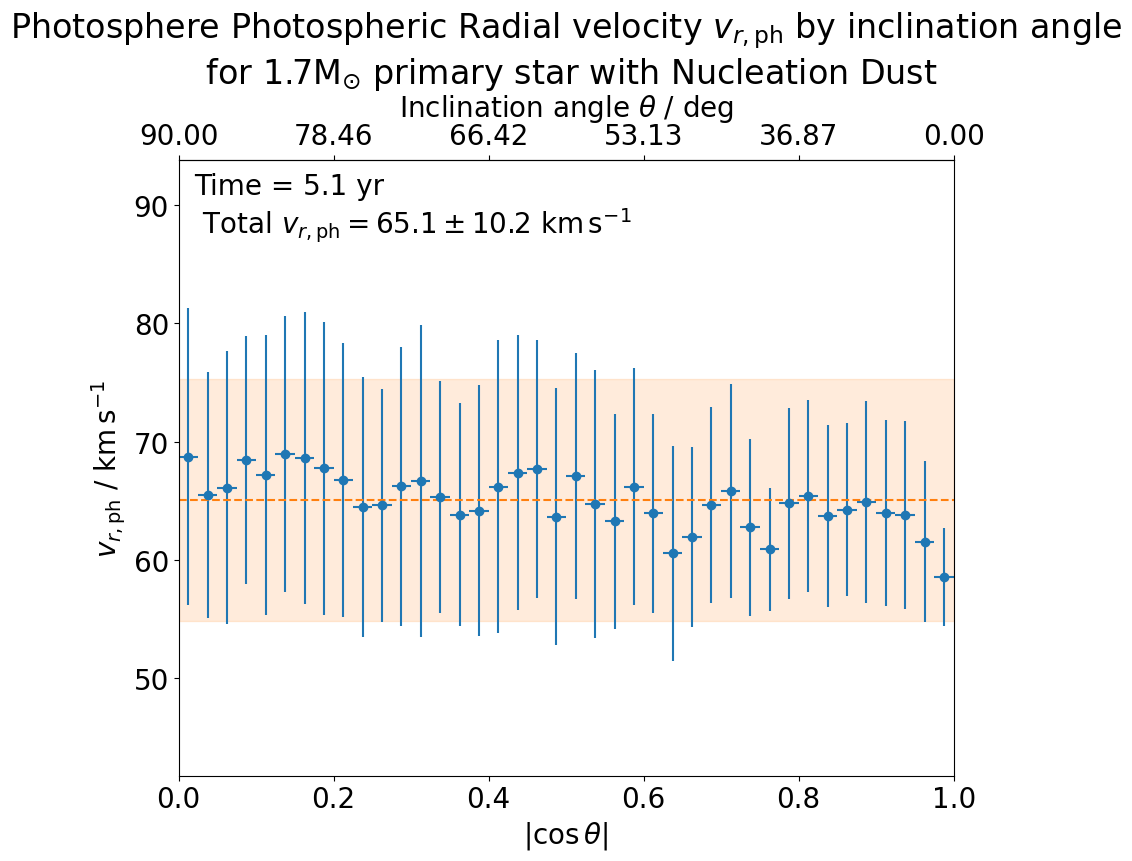

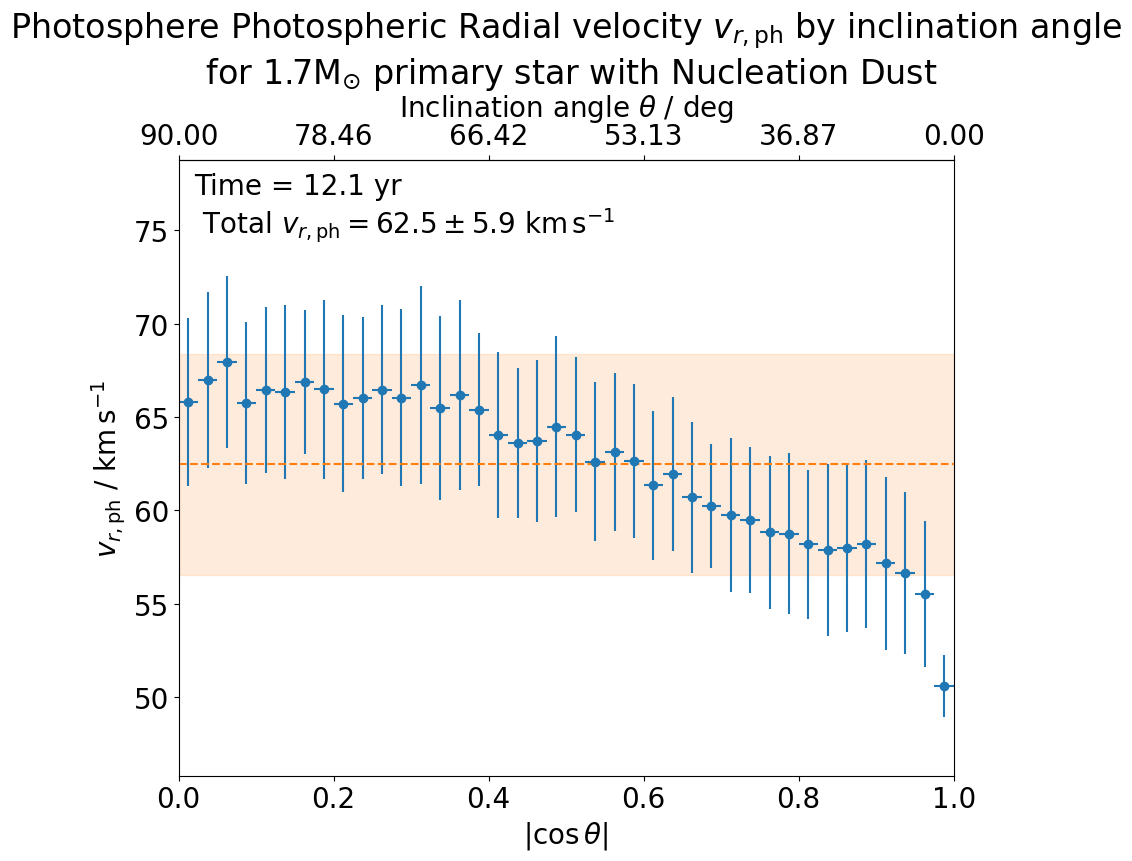

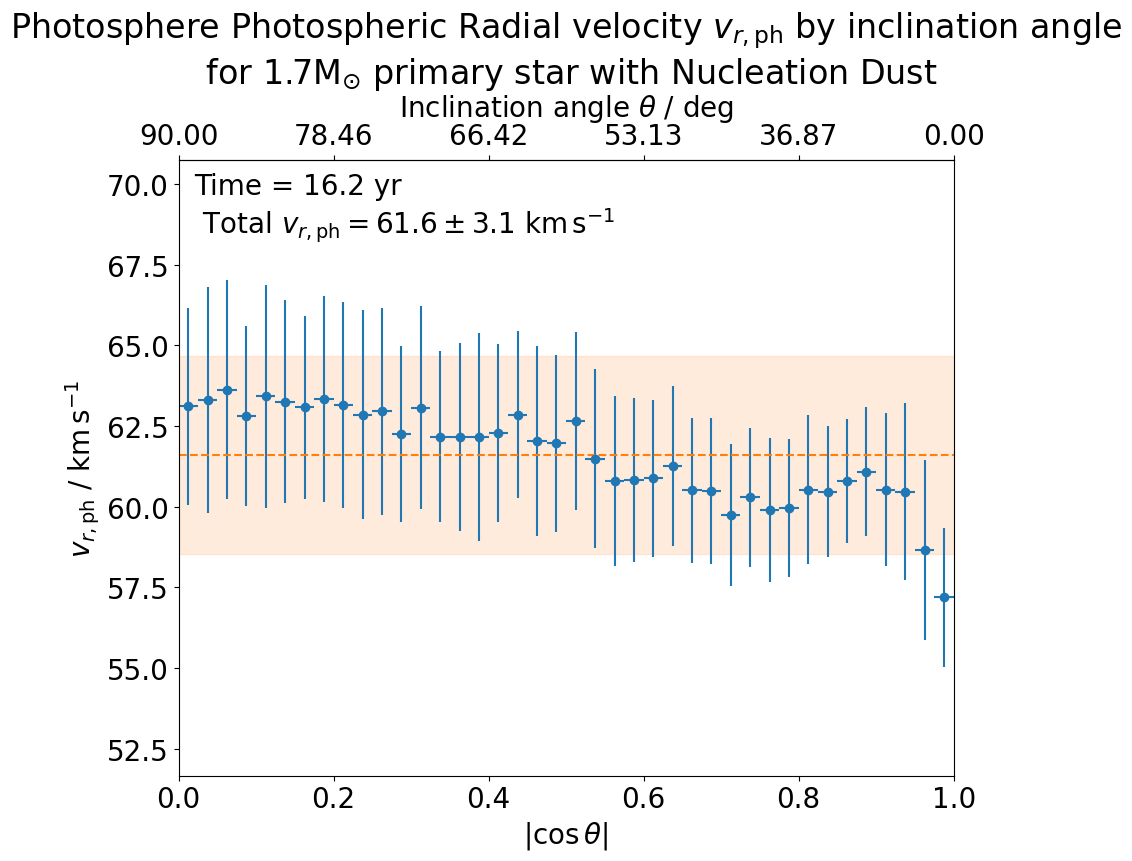

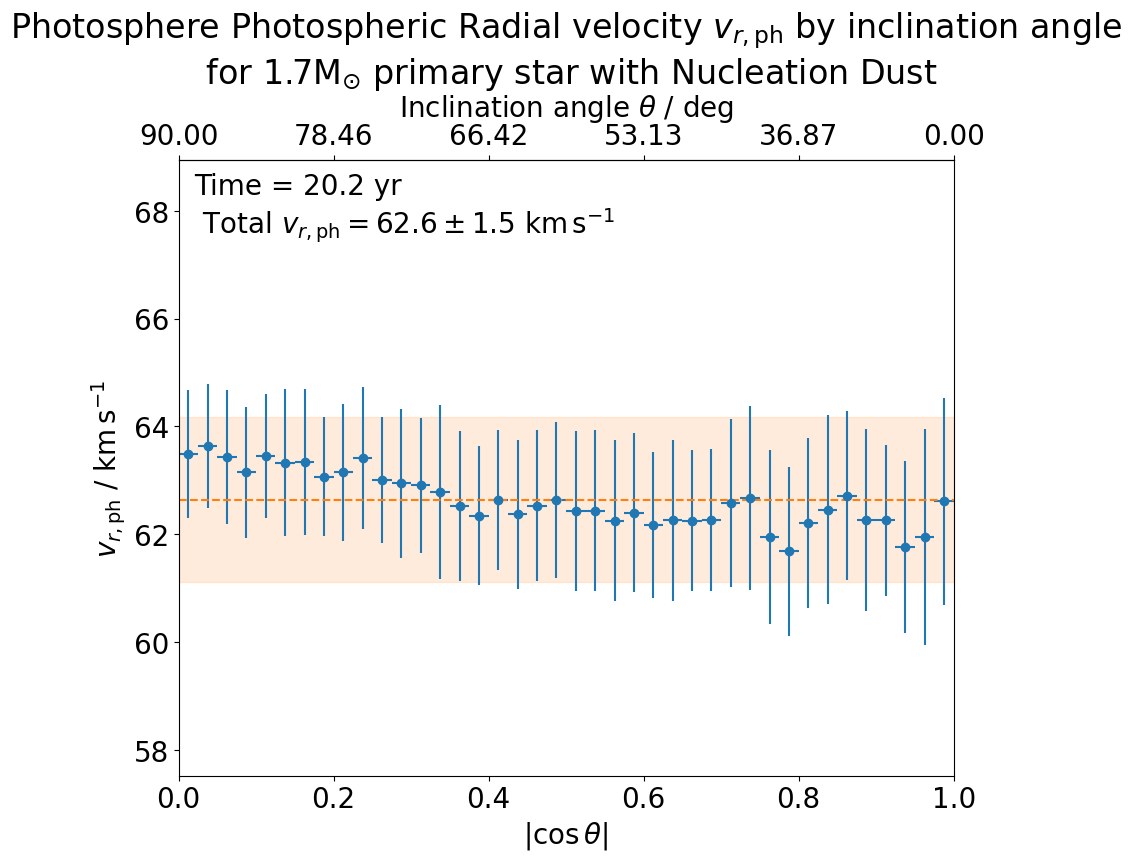

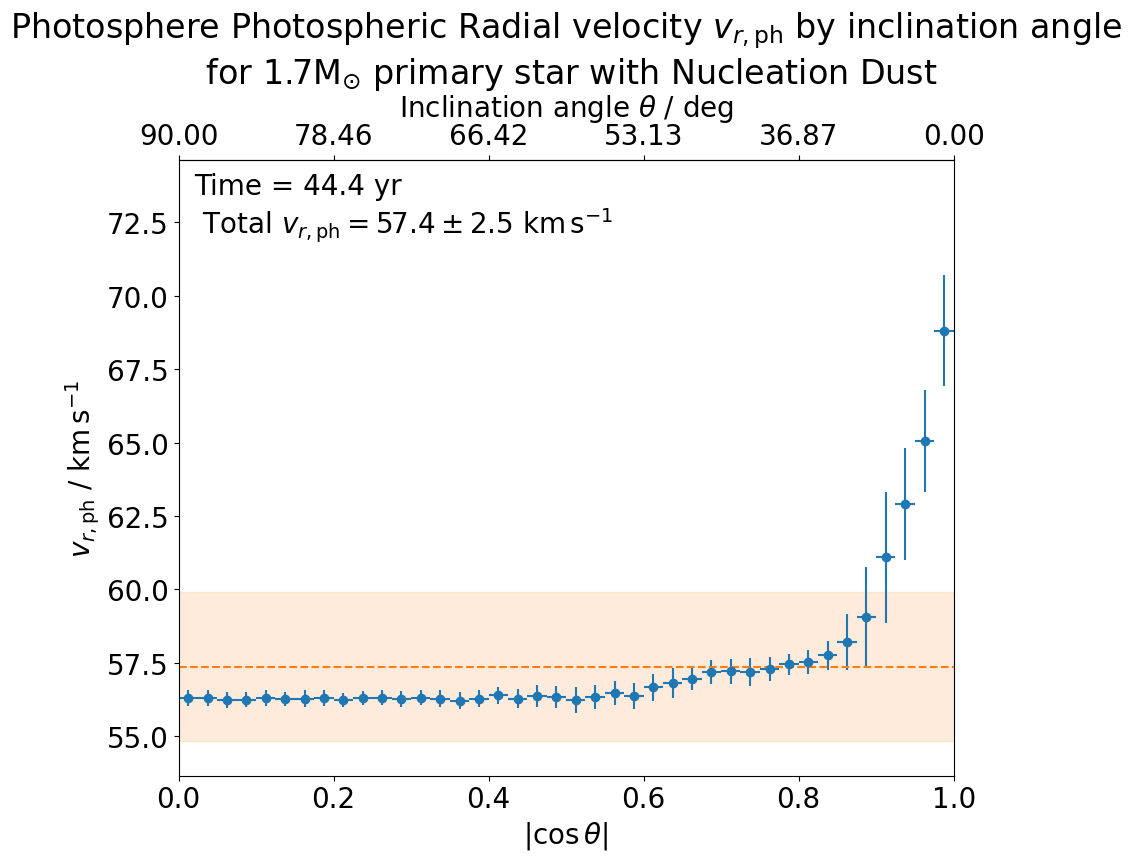

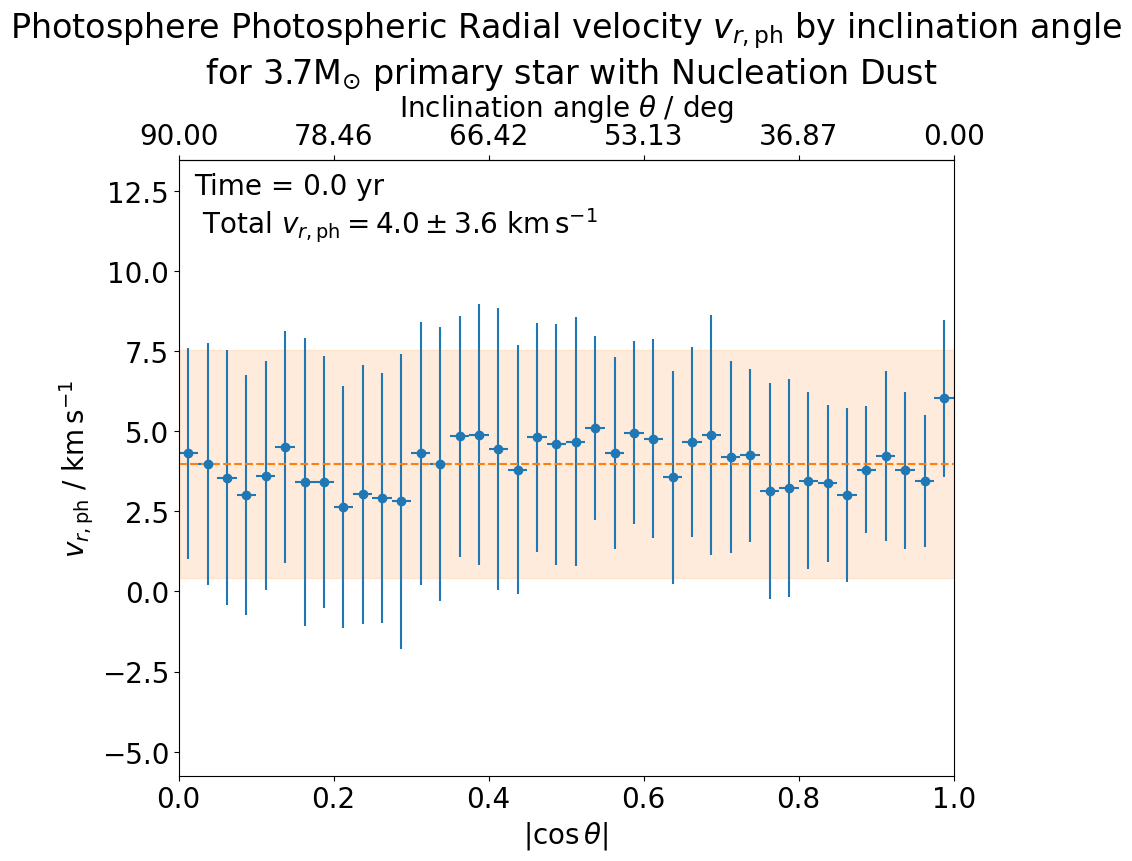

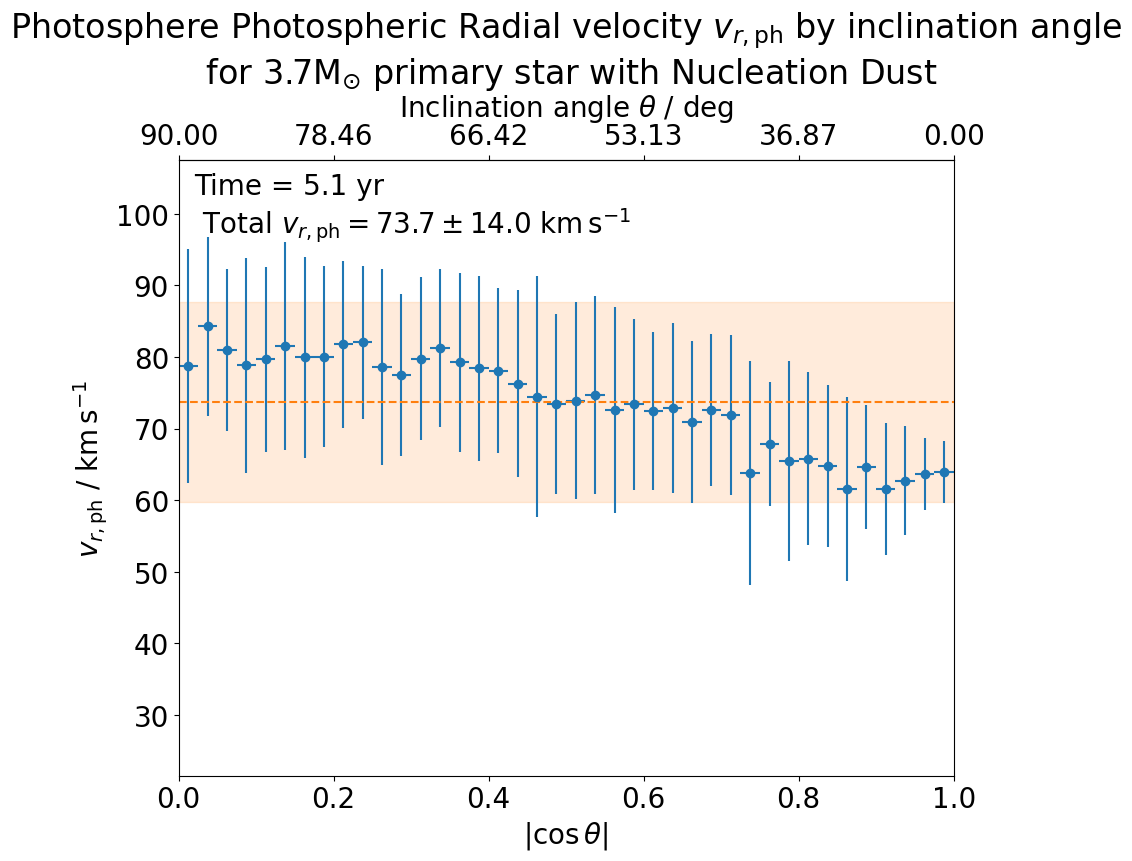

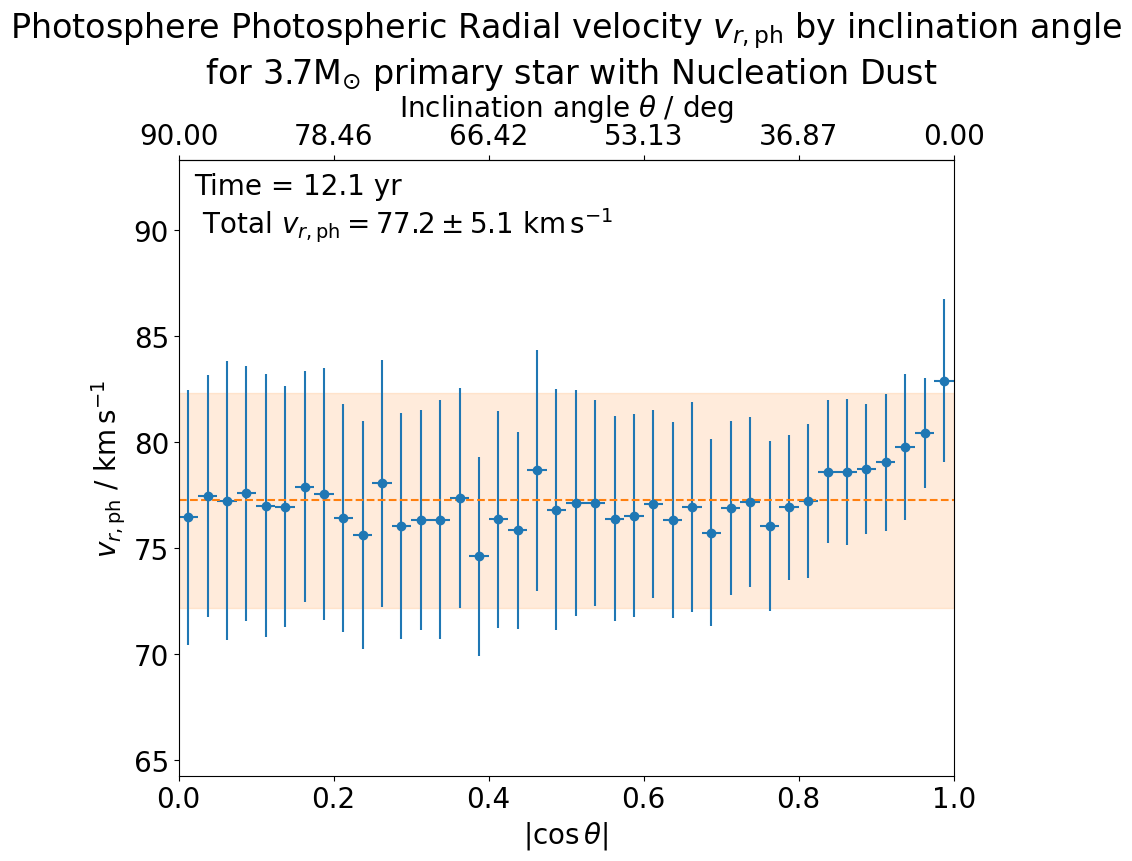

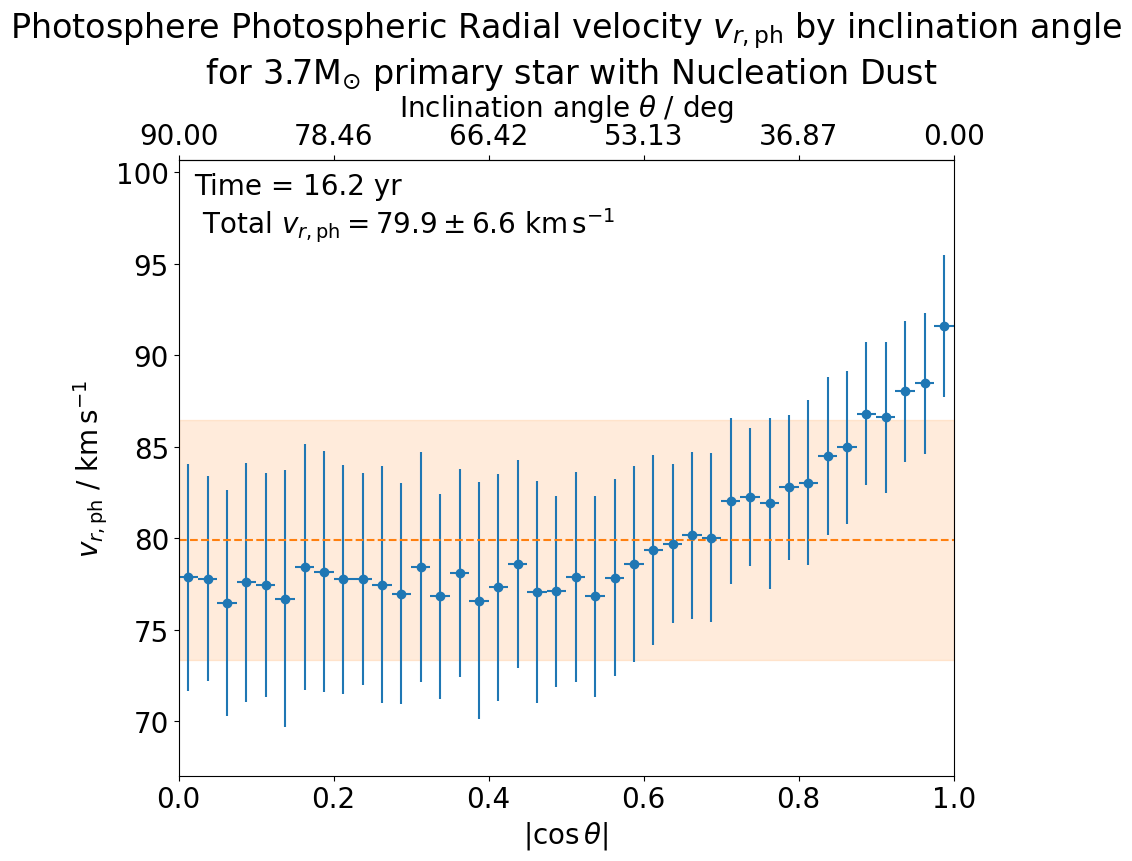

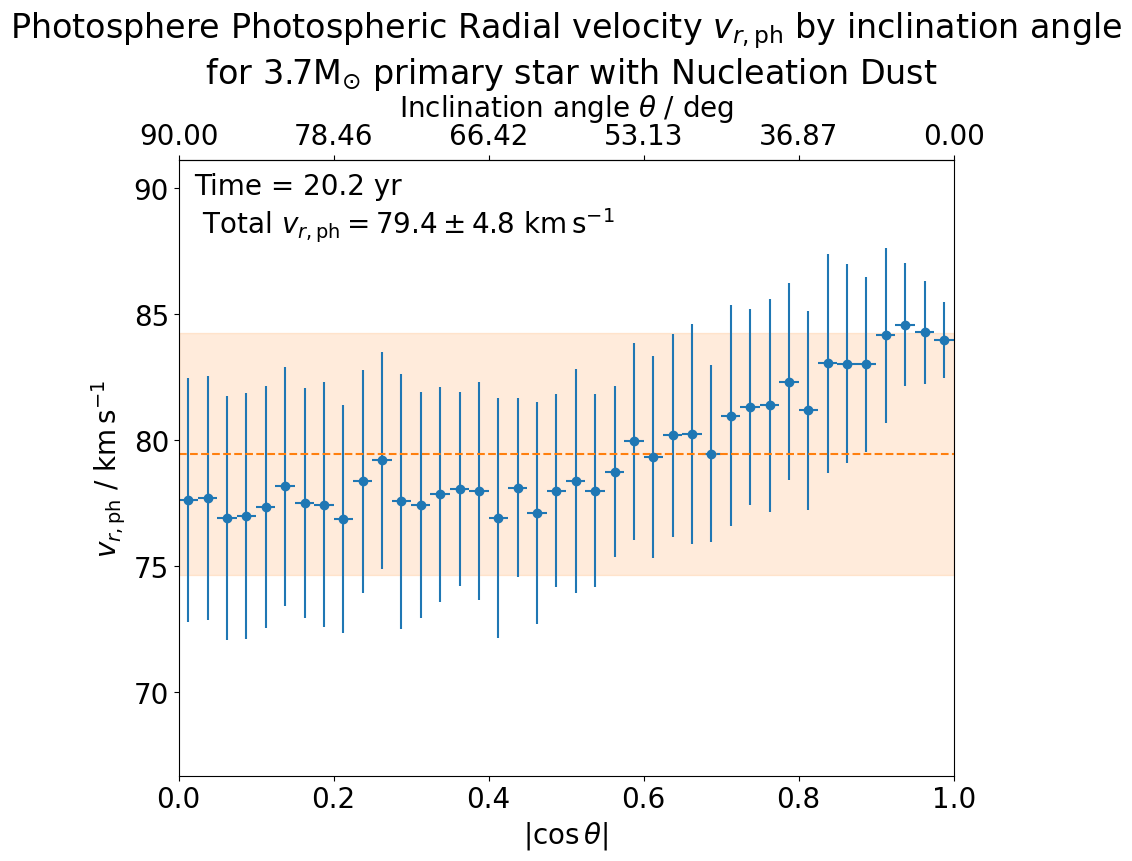

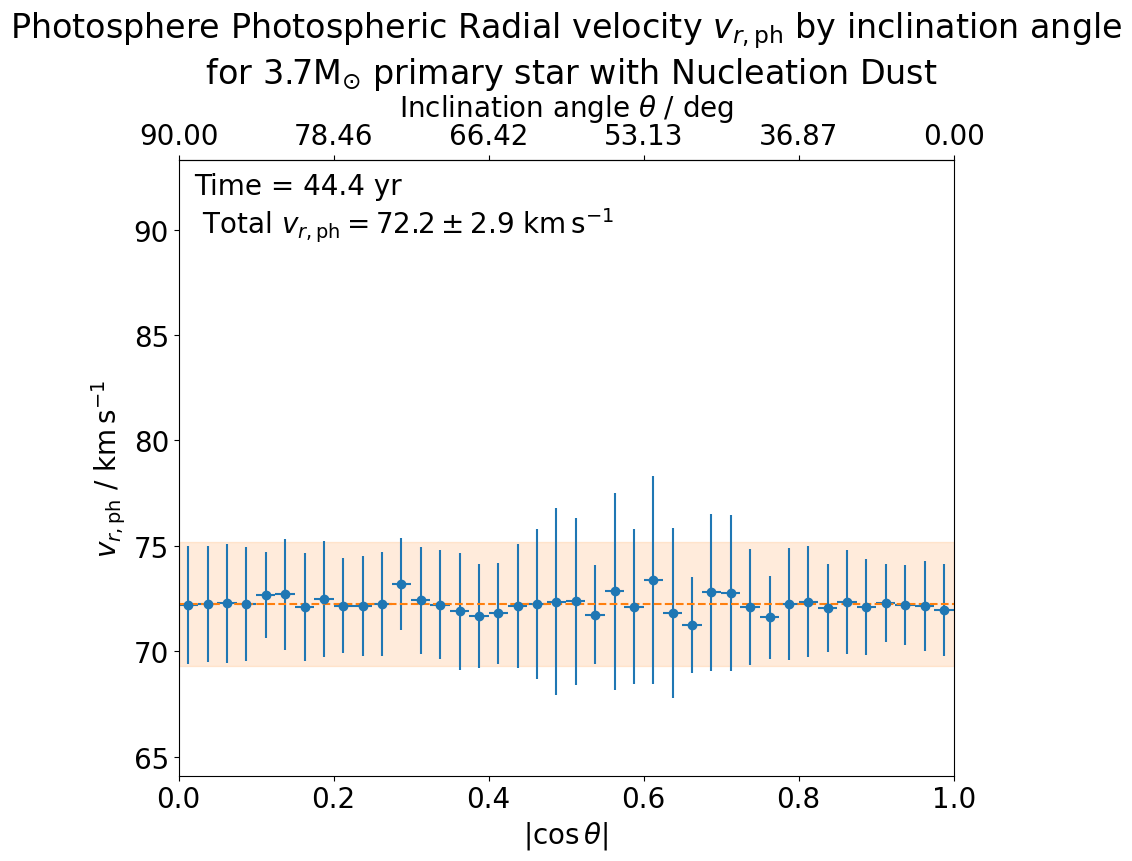

In [11]:
# plotting val vs incl

if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    

    for cos_theta_sample_no in [None, 40]:
        halflen = cos_theta_sample_no if cos_theta_sample_no is not None else 0
        for var_name in  ['vr']:#['T', 'R1']: # 'T', 'R1', 'rho', 'kappa', 'tau_dust'
            for job_nickname in ['2md', '4md']: #'4md', '2md', 
                outfilenames = []
                for file_index in [0, 2000, 4800, 6400, 8000, 17600]:
                    if file_index != 0 or var_name not in {'tau_dust'}:
                        fig, ax, outfilename = plot_ph_vals_vs_incl(
                            job_nickname, file_index, var_name,
                            cos_theta_sample_no=cos_theta_sample_no,
                            out_dir=out_dir, mpdf=mpdf, verbose=verbose)
                        outfilenames.append(outfilename)
                if True:
                    with ImageSequenceClip(outfilenames, fps=fps) as vid:
                        moviefilename = f"{out_dir}{job_nickname}__photosphere-vals_{var_name}-vs-incl_nbin{halflen:d}__movie.mp4"
                        vid.write_videofile(moviefilename)

    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

.

.

.

# Debug

.

.

.


In [50]:
job_nickname = '4md'
file_index = 17600

job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
ieos        = job_profile['ieos']
eos         = get_eos(ieos, params, settings)
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf        = mpdf_read(job_name, file_index, eos_opacity, mpdf, verbose=verbose)

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_17600'


*   Note   :    MyPhantomDataFrames.read():
	CoM significantly deviates from the origin with distance of 9.095893090194355.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
1372003 1372088


In [51]:
np.average(mpdf.get_val('v').to(units.km/units.s))

<Quantity 46.01288976 km / s>

In [46]:
np.count_nonzero(mpdf.get_val('vr') > )

85

In [52]:
np.average(mpdf.get_val('vr')).to(units.km/units.s)

<Quantity 45.98593282 km / s>

In [32]:
np.average(mpdf.get_val('vr').to(units.km/units.s))

KeyError: 'vr'

In [22]:
mpdf.units['time'].to(units.s)

1593.7103639003628

In [29]:
mpdf.units['dist'].to(units.Rsun)

1.0003593502946673

In [31]:
mpdf.get_filename()

'../photosphere/luis_4md/light_17600'

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_2md/light_02000'


*   Note   :    MyPhantomDataFrames.read():
	CoM significantly deviates from the origin with distance of 1.2814842488076321.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
8217 1372088
[15.0831085   8.06007453 29.87733191 ... 23.31837347 40.01311735
 16.78094501]
*   Note   :    plot_ph_vals_vs_incl():
	Figure saved to ../fig/2md_02000__photosphere-vals_tau_dust-vs-incl_nbin0.png
*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosp

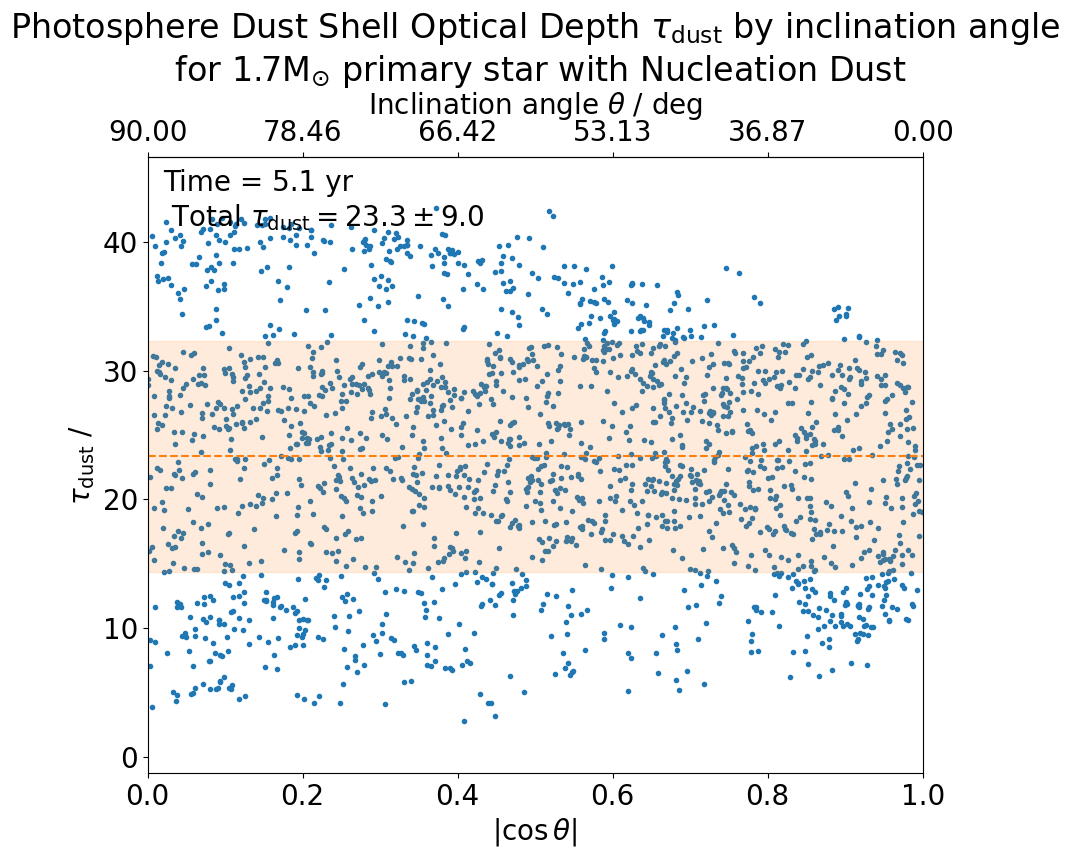

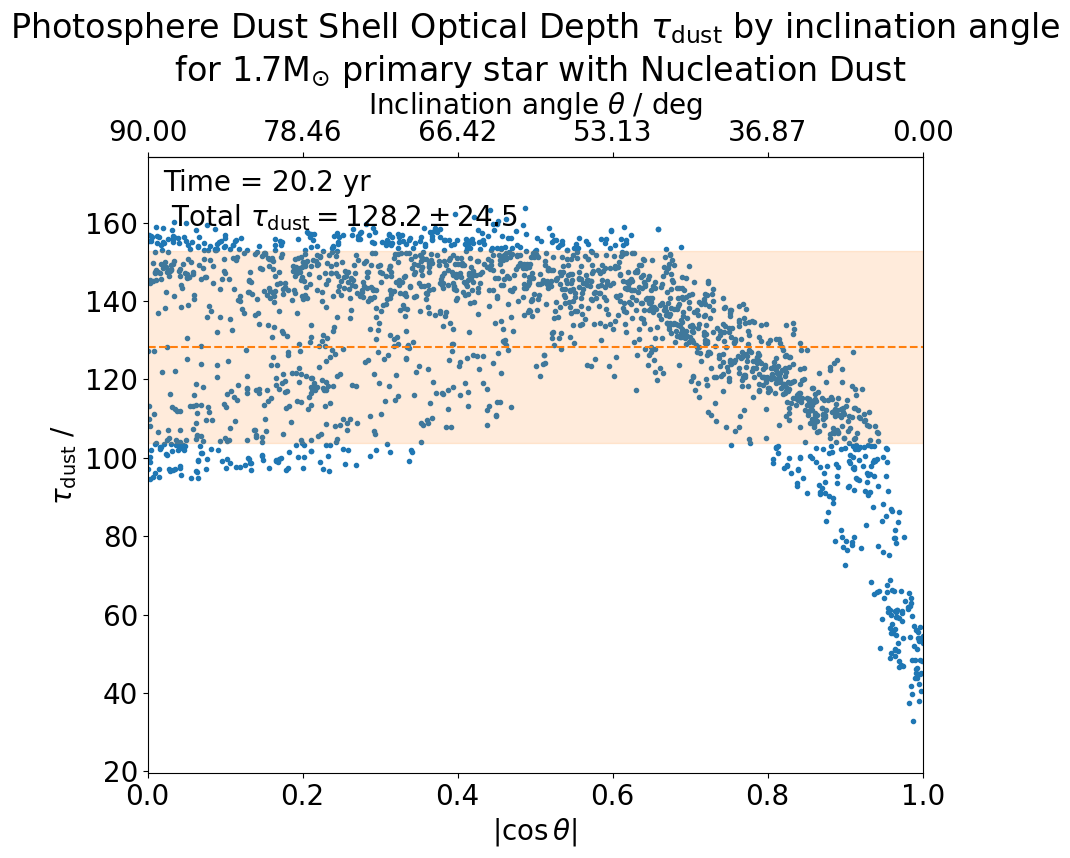

In [38]:
if __name__ == '__main__':
    mpdf = MyPhantomDataFrames()
    

    for cos_theta_sample_no in [None]:
        for job_nickname in ['2md']:
            for file_index in [2000, 8000]:
                for var_name in ['tau_dust']:
                    fig, ax = plot_ph_vals_vs_incl(
                        job_nickname, file_index, var_name,
                        cos_theta_sample_no=cos_theta_sample_no,
                        out_dir=out_dir, mpdf=mpdf, verbose=verbose)

    if is_verbose(verbose, 'note'):
        say('note', '__main__', verbose, f"\n\n\n*** All Done. ***\n\n\n")

In [15]:
job_nickname = '4md'
file_index   = 8000

job_profile = JOB_PROFILES_DICT[job_nickname]
job_name    = job_profile['job_name']
params      = job_profile['params']
ieos        = job_profile['ieos']
eos         = get_eos(ieos, params, settings)
eos_opacity = EoS_MESA_opacity(params, settings)
mpdf        = mpdf_read(job_name, file_index, eos_opacity, verbose=verbose)
with open(f"{mpdf.get_filename()}__photosphere-vals.json", 'r') as f:
    vals_dict = json_load(f)
    vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])

*   Note   :    MyPhantomDataFrames.read():
	

	Reading filename='../photosphere/luis_4md/light_08000'


*   Note   :    MyPhantomDataFrames.read():
	CoM significantly deviates from the origin with distance of 2.5425745046497634.
	Consider use reset_xyz_by_CoM=True option when read?
**  Warning:    MyPhantomDataFrames.read():
	kappa column exists.
	We here assume kappa is in phantom units self.units['opacity']=Unit("udist2 / umass") 
	However in phantom kappa is assumed to be in cgs unit.
	If so, please CONVERT KAPPA MANNUALLY into PHANTOM units BEFORE proceeding, e.g.:
		mpdf.data['gas']['kappa'] = mupl.units_util.get_val_in_unit(
		mpdf.data['gas']['kappa'], units.cm**2/units.g, mpdf.units['opacity'])
159649 1372088


In [16]:
vals_dict

{'tau_dust': array([46.67716929, 35.15595612, 44.02162602, ..., 35.00959874,
        49.221558  , 44.79030348]),
 'inner_dust_shell_rad': <Quantity [30318.1621318 , 38028.78553211, 30474.73626412, ...,
            32287.26816828, 29520.33196074, 32564.46449833] 6.9595e+10 cm>,
 'R1': <Quantity [49744.92385134,            nan,            nan, ...,
                       nan,            nan,            nan] 6.9595e+10 cm>,
 'T': <Quantity [486.10537682,          nan,          nan, ...,          nan,
                     nan,          nan] K>,
 'rho': <Quantity [1.10038421e-16,            nan,            nan, ...,
                       nan,            nan,            nan] 5.90096 g / cm3>,
 'kappa': <Quantity [2.43032179e+12,            nan,            nan, ...,
                       nan,            nan,            nan] 2.435e-12 cm2 / g>,
 'nneigh': array([67., nan, nan, ..., nan, nan, nan]),
 'vr': <Quantity [0.17240644,        nan,        nan, ...,        nan,        nan,
           

In [27]:
v_vecs = np.array(mpdf.data['gas'][['vx', 'vy', 'vz']])
r_vecs = np.array(mpdf.data['gas'][[ 'x',  'y',  'z']])
np.sum(v_vecs * r_vecs, axis=1) / np.sum(r_vecs**2, axis=1)**0.5

array([-0.00673544, -0.00938954,  0.01373044, ...,  0.0332853 ,
        0.02763445,  0.04848673])

In [36]:
set([1, 2, 3])

{1, 2, 3}

In [33]:
from astropy import constants as consts
consts.c.to(mpdf.units['speed'])

<Quantity 686.51820868 udist / utime>

In [16]:
mpdf.data['gas'][]

iorig            x            y            z    temperature  \
0              1    33.492966   -35.076257    11.307281  302459.319362   
1              2   -66.470066  -123.947939   199.853213   24718.611478   
2              3  -558.943075  -162.634380  -264.952254   10429.314261   
3              4 -1313.856141   185.985417   351.043441    8963.221971   
4              5   260.155621  -100.506288  -127.323804   27149.924468   
...          ...          ...          ...          ...            ...   
1372083  1372084   142.598636 -1398.557886  1329.307666    5277.388189   
1372084  1372085    29.094543   -27.601121   -20.885079  182177.071313   
1372085  1372086   -22.368953   -18.549878    12.052119  122619.598801   
1372086  1372087   187.195951    44.782133    12.168638   43199.621271   
1372087  1372088   252.651968  -192.859096    97.798348   23623.492071   

            gamma        vx        vy        vz         u  ...          Tdust  \
0        1.666667  0.036773  0.044733  0.000178  0.049677  ...  302459.319362   
1        1.666637  0.031629  0.002764  0.000753  0.008700  ...   24718.611478   
2        1.666667 -0.006218 -0.018661 -0.008573  0.005193  ...   10429.314261   
3        1.666667 -0.085207 -0.006586  0.024188  0.004433  ...    8963.221971   
4        1.666525  0.049355  0.010364 -0.028329  0.009075  ...   27149.924468   
...           ...       ...       ...       ...       ...  ...            ...   
1372083  1.666667  0.016868 -0.022294  0.040942  0.002303  ...    5277.388189   
1372084  1.666667  0.001298  0.018004  0.042799  0.029804  ...  182177.071313   
1372085  1.666667 -0.044732 -0.004458 -0.003001  0.022202  ...  122619.598801   
1372086  1.430707  0.021935  0.025722  0.005878  0.011402  ...   43199.621271   
1372087  1.666657  0.050425 -0.008986  0.016887  0.008602  ...   23623.492071   

                  h  alpha      divv         poten         m           rho  \
0          1.860715    1.0 -0.001442 -2.085284e-08  0.000002  5.889931e-07   
1          8.618285    1.0  0.000287 -1.063747e-08  0.000002  5.927712e-09   
2         32.448875    1.0  0.000148 -4.922421e-09  0.000002  1.110582e-10   
3         56.928329    1.0  0.000265 -2.394857e-09  0.000002  2.056668e-11   
4          8.847503    1.0  0.000583 -9.359292e-09  0.000002  5.478827e-09   
...             ...    ...       ...           ...       ...           ...   
1372083  205.996033    1.0  0.000109 -1.695499e-09  0.000002  4.340833e-13   
1372084    2.246101    1.0 -0.003182 -2.052713e-08  0.000002  3.348587e-07   
1372085    2.854178    1.0  0.001926 -2.018885e-08  0.000002  1.631948e-07   
1372086    5.722743    1.0  0.000963 -1.296872e-08  0.000002  2.024590e-08   
1372087    9.911401    1.0  0.000493 -8.787772e-09  0.000002  3.897127e-09   

                v              T  kappa_dust  
0        0.057907  302459.319362         0.0  
1        0.031759   24718.611478         0.0  
2        0.021457   10429.314261         0.0  
3        0.088818    8963.221971         0.0  
4        0.057843   27149.924468         0.0  
...           ...            ...         ...  
1372083  0.049576    5277.388189         0.0  
1372084  0.046450  182177.071313         0.0  
1372085  0.045054  122619.598801         0.0  
1372086  0.034313   43199.621271         0.0  
1372087  0.053931   23623.492071         0.0  

[1372088 rows x 30 columns]

    # plotting T vs inclination angle (from both neg and positive cos sides)
    
    if __name__ == '__main__':
        fig, ax = plt.subplots(figsize=(8, 8))
        x = cos_thetas
        xerr = cos_theta_delta
        y_data = [ vals_dict['T'] for vals_dict in vals_by_cos_thetas ]
        y = np.average(y_data, axis = 1)
        yerr =  np.std(y_data, axis = 1)
        #ax.plot(x, y, 'o-')
        #ax.fill_between(x, y-yerr, y+yerr, alpha=0.15)
        ax.errorbar(x, y, yerr, xerr, 'o')
    
        ax.set_xlim((-1., 1.))
        ax.set_ylim((300, 500))
        ax.set_xlabel("$\\cos{\\theta}$")
        ax.set_ylabel(f"$T$ / {mpdf.units['temp']}")
    
        plt.show()

In [26]:
help(mupl.get_filename_phantom_dumps)

Help on function get_filename_phantom_dumps in module clmuphantomlib.mpdf:

get_filename_phantom_dumps(job_name: str, file_index: int) -> str
    Return phantom dumps filename.



In [26]:
vals_units = {
    'R1': units.Rsun,
    'T' : units.K,
    'vr': units.km/units.s,
    'L_est': units.Lsun,
}

for jobnickname in ['2md', '4md']:
    print('\n', jobnickname)
    job_profile = JOB_PROFILES_DICT[jobnickname]
    for file_index in [0, 17600]: #[4800, 5600, 17600]:
        job_name    = job_profile['job_name']
        filename    = mupl.get_filename_phantom_dumps(job_name, file_index)
        with open(f"{filename}__photosphere-vals.json", 'r') as f:
            vals_dict  = json_load(f, remove_metadata=False)
            vals_dict['abs_cos_theta'] = np.abs( vals_dict['cos_theta'])
            vals_dict['L_est'] = const.sigma_sb * vals_dict['T']**4 * 4 * np.pi * vals_dict['R1']**2
        print(f"time = {vals_dict['time']: .2f}")
        for val in ['R1', 'T', 'vr', 'L_est']:
            print(
                f"\t{val}: ",
                f"{np.average(vals_dict[val]).to_value(vals_units[val]): .2f}",
                f"+/-{np.std(vals_dict[val]).to_value(vals_units[val]): .2f} {vals_units[val]}")


 2md
time =  0.00 yr
	R1:   448.85 +/- 14.96 solRad
	T:   6531.54 +/- 332.44 K
	vr:   6.29 +/- 4.69 km / s
	L_est:   337199.75 +/- 77242.38 solLum
time =  44.44 yr
	R1:   96689.34 +/- 2905.32 solRad
	T:   378.23 +/- 21.50 K
	vr:   57.57 +/- 2.89 km / s
	L_est:   178529.68 +/- 62122.69 solLum

 4md
time =  0.00 yr
	R1:   481.00 +/- 21.00 solRad
	T:   8795.13 +/- 184.63 K
	vr:   4.04 +/- 3.51 km / s
	L_est:   1247021.01 +/- 88341.79 solLum
time =  44.44 yr
	R1:   116320.28 +/- 8225.03 solRad
	T:   409.63 +/- 24.46 K
	vr:   72.13 +/- 2.97 km / s
	L_est:   356481.58 +/- 142123.79 solLum


In [25]:
(6531.54 / 3227 )**4 * (448.85/260)**2 * 5.18

259.090819516721

In [27]:
337199.75 / 5.18e3

65.09647683397684

In [20]:
vals_dict['L_est'].to(units.Lsun)

<Quantity [423511.87614069, 306857.6078571 , 371334.1112634 , ...,
           258670.74778305, 320629.66170944, 441719.57450371] solLum>

In [14]:
T  = 6531.54 * units.K
R1 =  448.85 * units.Rsun
L  = (const.sigma_sb * T**4 * 4 * np.pi * R1**2).to(units.Lsun)
L/1e5

<Quantity 3.30337974 solLum>

In [13]:
np.average(vals_dict['vr']).to(units.km/units.s)

<Quantity 4.04340692 km / s>

In [90]:
for i in range(5):
    print(f"{i=:3d}, {np.count_nonzero(vals_dict['nneigh']==i) = }")
print(f"{i=:3d}, {np.count_nonzero(vals_dict['nneigh']> i) = }")

i=  0, np.count_nonzero(vals_dict['nneigh']==i) = 0
i=  1, np.count_nonzero(vals_dict['nneigh']==i) = 1779
i=  2, np.count_nonzero(vals_dict['nneigh']==i) = 210
i=  3, np.count_nonzero(vals_dict['nneigh']==i) = 10
i=  4, np.count_nonzero(vals_dict['nneigh']==i) = 1
i=  4, np.count_nonzero(vals_dict['nneigh']> i) = 0


In [77]:
vals_dict['h' ] = vals_dict['h' ].to(units.Rsun)
vals_dict['R1'] = vals_dict['R1'].to(units.Rsun)
vals_dict['kappa'] = vals_dict['kappa'].cgs
vals_dict

{'R1': <Quantity [484.66331106, 507.02169162, 528.65699113, ..., 466.4920071 ,
            471.99673385, 481.50519306] solRad>,
 'T': <Quantity [8831.8945366 , 8702.08890954, 8488.90746876, ..., 9050.6937566 ,
            8733.21227787, 8968.73462593] K>,
 'rho': <Quantity [3.23679651e-11, 2.62186606e-11, 1.76308043e-11, ...,
            5.06089861e-11, 4.65824075e-11, 4.16218598e-11] 5.90096 g / cm3>,
 'kappa': <Quantity [3.50306473, 2.82076286, 1.98344933, ..., 4.96392222, 3.51690647,
            4.36379332] cm2 / g>,
 'nneigh': array([1., 1., 1., ..., 1., 1., 1.]),
 'cos_theta': array([-0.56575654, -0.08463539, -0.67400479, ...,  0.80820999,
        -0.22221337,  0.15921991]),
 'ray_unit_vec': array([[ 0.37404891,  0.73485165, -0.56575654],
        [-0.19186056,  0.97776601, -0.08463539],
        [ 0.19786783, -0.7117344 , -0.67400479],
        ...,
        [-0.5190868 , -0.27811059,  0.80820999],
        [-0.42558501,  0.8772107 , -0.22221337],
        [ 0.00628401,  0.98722314,  0

In [53]:
np.average(vals_dict['h']), np.std(vals_dict['h'])

(<Quantity 48.4005266 solRad>, <Quantity 5.8984604 solRad>)

In [52]:
np.average(vals_dict['R1']), np.std(vals_dict['R1'])

(<Quantity 480.86289973 solRad>, <Quantity 20.93819047 solRad>)

In [69]:
np.average(vals_dict['kappa']), np.std(vals_dict['kappa'])

(<Quantity 3.55852921 cm2 / g>, <Quantity 1.04907401 cm2 / g>)

In [76]:
np.average(vals_dict['rho'].cgs), np.std(vals_dict['rho'].cgs)

(<Quantity 2.16031423e-10 g / cm3>, <Quantity 8.036891e-11 g / cm3>)

In [75]:
np.average(vals_dict['h'].cgs), np.std(vals_dict['h'].cgs)

(<Quantity 3.36722464e+12 cm>, <Quantity 4.1035589e+11 cm>)

In [81]:
vals_dict['tau_estimate'] = (vals_dict['kappa']*vals_dict['rho']*vals_dict['h']).to_value(units.dimensionless_unscaled)

In [83]:
np.average(vals_dict['tau_estimate']), np.std(vals_dict['tau_estimate'])

(2640.407762804697, 1426.4846666323972)

In [73]:
4*pi*480**2/(48**2)

1256.6370614359173

In [71]:
eos_opacity.get_kappa(rho=3e-11, T=8500)

1.351652488736986

In [21]:
help(mupl.sph_interp.get_h_from_rho)

Help on CPUDispatcher in module main.clmuphantomlib.sph_interp:

get_h_from_rho(rho: numpy.ndarray | float, mpart: float, hfact: float, ndim: int = 3) -> numpy.ndarray | float
    Getting smoothing length from density.
    
    Assuming Phantom, where smoothing length h is dynamically scaled with density rho using
    rho = hfact**ndim * (m / h**ndim)
    for ndim-dimension and hfact the constant.
    So,
    h = hfact * (mpart / rho)**(1./ndim)

